#**0. CONFIGURACIÓN DEL ENTORNO Y PREPROCESADO**
Antes de iniciar a aplicar cualquier técnica, importamos todas las librerias necesarias para el análisis, instalando aquellas externas necesarias, y unificamos las bases de datos.


##0.1 Instalación e importación de librerías y datasets

In [1]:
# Instalar librerias externas necesarias
!pip install pyreadstat
!pip install factor_analyzer    # Test de esfericidad de Bartlett
!pip install pingouin           # Test de normalidad multivariante

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=64cac55f63ea49651510e39ba12a09836be9ad5cd2392002697c2857eb0be8c4
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.4 MB/s eta 0:00:00


In [2]:
# Importar librerias y definir repositorios de donde descargar las DB
import pandas as pd
import numpy as np
from scipy import stats
import requests
import pyreadstat
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pingouin as pg

pd.options.display.max_seq_items = None # Elimina el límite de visualización

url_bd_hogares = "https://github.com/moisesjf10/Estadistica-Multivariante/raw/main/BBDD_Hogares_Seguridad_Alimentaria.sav"
url_bd_menores = "https://github.com/moisesjf10/Estadistica-Multivariante/raw/main/BBDD_Menores_0-59meses_Antropometria.sav"


In [3]:
#Descargar y guardar físicamente en el entorno de Colab
def descargar_archivo_spss(url, nombre_local):
    response = requests.get(url)
    if response.status_code == 200:
        with open(nombre_local, 'wb') as f:
            f.write(response.content)
        print(f"Archivo {nombre_local} descargado con éxito.")
    else:
        print(f"Error al descargar {nombre_local}: {response.status_code}")



In [4]:
# Ejecutamos la descarga
descargar_archivo_spss(url_bd_hogares, "hogares.sav")
descargar_archivo_spss(url_bd_menores, "menores.sav")

# Ahora leemos los archivos desde el disco local de Colab
df_hogares, meta_hogares = pyreadstat.read_sav("hogares.sav")
df_menores, meta_menores = pyreadstat.read_sav("menores.sav")

# Ver los resultados
print("\nBase de Hogares cargada:", df_hogares.shape)
print("Base de Menores cargada:", df_menores.shape)

Archivo hogares.sav descargado con éxito.
Archivo menores.sav descargado con éxito.

Base de Hogares cargada: (912, 194)
Base de Menores cargada: (705, 99)


In [5]:
# Función para imprimir nombres y etiquetas de forma organizada
def listar_columnas(meta, titulo):
    print(f"\n--- {titulo} ({len(meta.column_names)} columnas) ---")
    for col, label in meta.column_names_to_labels.items():
        print(f"{col}: {label}")



In [6]:
# Listar ambas
listar_columnas(meta_hogares, "BASE DE HOGARES")
listar_columnas(meta_menores, "BASE DE MENORES")


--- BASE DE HOGARES (194 columnas) ---
ID_HOGAR: Identificacion Hogar
ESTRATO: Estrato
DPTO: Departamento
CLUSTER: Cluster
HOGAR: Numero Hogar
EQUIPO: Equipo
FECHA: Fecha
DIA: Dia
MESES: Meses
ANHOS: Años
TAMANHO_HOG: Numero de Personas
ID$01: ID Persona
ID$02: ID Persona
ID$03: ID Persona
ID$04: ID Persona
ID$05: ID Persona
ID$06: ID Persona
ID$07: ID Persona
ID$08: ID Persona
ID$09: ID Persona
ID$10: ID Persona
ID$11: ID Persona
ID$12: ID Persona
ID$13: ID Persona
ID$14: ID Persona
ID$15: ID Persona
ID$16: ID Persona
ID$17: ID Persona
ID$18: ID Persona
ID$19: ID Persona
ID$20: ID Persona
ID$21: ID Persona
ID$22: ID Persona
ID$23: ID Persona
ID$24: ID Persona
ID$25: ID Persona
ID$26: ID Persona
ID$27: ID Persona
ID$28: ID Persona
ID$29: ID Persona
ID$30: ID Persona
SEXO$01: Sexo
SEXO$02: Sexo
SEXO$03: Sexo
SEXO$04: Sexo
SEXO$05: Sexo
SEXO$06: Sexo
SEXO$07: Sexo
SEXO$08: Sexo
SEXO$09: Sexo
SEXO$10: Sexo
SEXO$11: Sexo
SEXO$12: Sexo
SEXO$13: Sexo
SEXO$14: Sexo
SEXO$15: Sexo
SEXO$16: Sex

##0.2. Unificación y preparación del Dataset
Ahora vamos a realizar la unificación de las dos bases de datos que nos han dado y, tras ello, realizaremos otros cambios para dejar el dataset listo para el análisis.

Primero vamos a eliminar las columnas que no necesitamos de ambas bases de datos.

In [7]:
# --- LIMPIEZA HOGARES ---
# Columnas que queremos quitar (filtros y desglose de miembros)
cols_a_quitar_hogares = [
    'EQUIPO', 'FECHA', 'DIA', 'MESES', 'ANHOS', 'LLEGO$01'
]
# Quitamos todas las de ID$, SEXO$ y EDAD$ (miembros del hogar)
cols_a_quitar_hogares += [c for c in df_hogares.columns if any(x in c for x in ['ID$', 'SEXO$', 'EDAD$'])]
# Quitamos los filtros
cols_a_quitar_hogares += [c for c in df_hogares.columns if 'filter_$' in c or 'F$' in c]

df_hogares_limpia = df_hogares.drop(columns=cols_a_quitar_hogares)

In [8]:
# --- LIMPIEZA MENORES ---
# Quitamos repetidas con hogares y filtros
cols_a_quitar_menores = [
    'ESTRATO', 'SURVDATE', 'CLUSTER', 'TEAM', 'ID', 'HOGAR', 'DPTO'
]
cols_a_quitar_menores += [c for c in df_menores.columns if 'filter_$' in c or 'F$' in c]

df_menores_limpia = df_menores.drop(columns=cols_a_quitar_menores)

Tras eliminar las columnas que no necesitamos (datos innsecesarios y columnas repetidas en ambas bases de datos), unimos ambas bases de datos. Vamos a unirlas por el ID. En la base de datos de menores tenemos la columna 'ID_UNICO', cuyos primeros 5 dígitos corresponden al ID del hogar. Por tanto, realizamos la división entera entre 100 para obtener este ID.

In [9]:
# --- UNIFICACIÓN ---
# Crear ID_HOGAR en menores usando división entera
df_menores_limpia['ID_HOGAR'] = (df_menores_limpia['ID_UNICO'] // 100).astype(int)
df_hogares_limpia['ID_HOGAR'] = df_hogares_limpia['ID_HOGAR'].astype(int)

# Merge. Hago left join (tabla de menores como principal) para coger las 705 filas
df_unificada = pd.merge(df_menores_limpia, df_hogares_limpia, on='ID_HOGAR', how='left')

print(f"La base de datos unificada tiene {df_unificada.shape[0]} filas y {df_unificada.shape[1]} columnas.")

La base de datos unificada tiene 705 filas y 154 columnas.


In [10]:
print(list(df_unificada.columns))


['ID_UNICO', 'SEX', 'BIRTHDAT', 'MONTHS', 'WEIGHT', 'HEIGHT', 'EDEMA', 'MUAC', 'ID_MADRE', 'DIARREA', 'FIEBRE', 'INFEC_RE', 'DESPARAS', 'VACC_SAR', 'CLUSTER_A_x', 'HOGAR_A_x', 'ID_A', 'VACC_SAR_AGRUP', 'GAM', 'SUNTING', 'UNDERWEIGHT', 'SEXO_303', 'EDAD_304', 'AMAMANT_305', 'TIEMPO_1RA_VEZ_306', 'AMAMANT_HOY_307', 'AMAMANT_MESES_308', 'SUPL_VIT_A_309', 'AGUA_310_A', 'FORM_310_B1', 'FORM_VEZ_310_B2', 'LECH_310_C1', 'LECH_310_C2', 'ATOL_310_D', 'JUGO_310_E', 'CAFE_310_F', 'LIQU_310_G', 'PACH_311', 'PURE_312_A', 'FRIJO_312_B', 'LACT_312_C', 'CARN_312_D', 'HUEV_312_E', 'VERD_312_F', 'FRUT_312_G', 'GRAS_312_H', 'AZUC_312_I', 'COMIDAS_VEZ_313', 'LACT_TEMP', 'LACT_EXCL', 'INTRO_ALIM', 'GA1', 'GA2', 'GA3', 'GA4', 'GA5', 'GA6', 'GA7', 'GA8', 'GA9', 'DA_MIN_SC', 'DA_MIN_CLASF', 'FRQ_MIN_COM', 'DIET_MIN_ACEP', 'INT_EDAD_2MES', 'LACT_Y_SSOLD', 'LACT_Y_LIQ', 'LACT_Y_LECH', 'LACT_Y_AGUA', 'NO_LACT', 'ID_HOGAR', 'ESTRATO', 'DPTO', 'CLUSTER', 'HOGAR', 'TAMANHO_HOG', 'HOGAR_A_y', 'HOGAR_B', 'HOGAR_C', '

Una vez unificadas las dos bases de datos, vamos a eliminar otras columnas innecesarias y unir algunas columnas

Primero vamos a unir las dos columnas de CSI como se indica en las pautas.

In [11]:
# Unificamos las dos columnas de CSI en una sola
# Si un hogar está en Occidente, tomará ese valor; si está en Oriente, el otro.
df_unificada['CSI_final'] = df_unificada['CSIr2_OCC'].fillna(df_unificada['CSIr2_ORI'])

# Verificamos que no hayan quedado vacíos (debería haber datos para los 705 casos)
print(f"Valores nulos en CSI_final: {df_unificada['CSI_final'].isna().sum()}")

Valores nulos en CSI_final: 3


Ahora vamos a eliminar otras columnas.
Las columnas 'WEIGHT', 'HEIGHT', 'MUAC' y 'EDEMA' que ya están procesadas en GAM, Stunting y Underweight. También quitamos las fechas, nombres de equipos e ID que no aportan al análisis estadístico, y las variables redundantes

In [12]:
cols_borrar = [
    'WEIGHT', 'HEIGHT', 'MUAC', 'EDEMA', 'BIRTHDAT',               # ya procesadas
    'CSIr2_OCC', 'CSIr2_ORI',                          # Ya unificadas
    'SURVDATE', 'TEAM', 'CLUSTER', 'ID_MADRE', 'ID',    # Metadatos técnicos
    'ID_A', 'HOGAR_A', 'CLUSTER_A', 'EQUIPO', 'FECHA'
]
df_unificada=df_unificada.drop(columns=cols_borrar, errors='ignore')
print(f"Columnas restantes: {len(df_unificada.columns)}")

Columnas restantes: 145


Hay algunas columnas sin codificar y que contienen texto abierto. Por la dificultad de que conlleva, decidimos eliminarlas.

In [13]:
df_unificada=df_unificada.drop(columns=['JORNAL_DETALLE_A2', 'OTRO_DETALLE_B2',
    'COMERCIO_DETALLE_C2', 'VENTA_PROD_DETALLE_D2'], errors='ignore')

print(f"La base de datos ahora tiene {df_unificada.shape[0]} registros y {df_unificada.shape[1]} columnas.")

La base de datos ahora tiene 705 registros y 141 columnas.


Con esto ya tenemos lista la base datos para empezar con el análisis univariante

#**1. ANÁLISIS UNIVARIANTE**

##1.1. Tratamiento de valores faltantes
Para el tratamiento de valores faltantes vamos a seguir los siguientes pasos:

1.   Identificar el porcentaje de valores faltantes
2.   Si es mayor al 5%, estudiamos si el patrón de datos perdidos es aleatorio o no, estudiando la homogeneidad entre NA - no NA. Para ello usaremos la prueba t de Student en el caso continuo, o la prueba de independencia Chi cuadrado en el caso discreto o cualitativo.
3. Finalmente, si se acepta la homogeneidad (el patrón es aleatorio), los NA se sustituyen por la media o la mediana, dependiendo de si es cuantitativo o cualitativo. Si el patrón no es aleatorio, habría que consultar que hacer, pero simpre trabajaremos como si lo fuera.



In [14]:
def imputar_nas_con_lista_homogeneidad(df, meta):
    """
    Imputa NAs detectando si usar Media, Mediana o Moda, y devuelve la lista para tests.
    """
    df_limpio = df.copy()
    columnas_con_nas = df.columns[df.isnull().any()].tolist()
    lista_homogeneidad = []

    print(f"--- Iniciando proceso de imputación para {len(columnas_con_nas)} variables ---\n")

    for col in columnas_con_nas:
        total_na = df[col].isnull().sum()
        pct_na = (total_na / len(df)) * 100

        # Es cualitativa si está en metadata, es objeto (texto) o es de las escalas clave
        es_cualitativa = (col in meta.variable_value_labels and len(meta.variable_value_labels[col]) > 0) or \
                         (df[col].dtype == 'object') or (str(df[col].dtype) == 'category') or \
                         any(x in col for x in ['CSI', 'ELCSA', 'GAM', 'SUNTING', 'UNDERWEIGHT'])

        if pct_na > 5:
            lista_homogeneidad.append(col)
            alerta = "[REQUIERE TEST]"
        else:
            alerta = "[OK]"

        # 2. Lógica de Imputación Protegida
        if es_cualitativa:
            # Si es numérica (códigos 0,1,2), usamos Mediana. Si es texto ('HUE'), usamos Moda.
            if pd.api.types.is_numeric_dtype(df[col]):
                valor_imputado = df[col].median()
                tipo_str = "CUALITATIVA (Mediana)"
            else:
                # La moda devuelve una serie, tomamos el primer elemento [0]
                valor_imputado = df[col].mode()[0]
                tipo_str = "CUALITATIVA (Moda)"
        else:
            # Cuantitativa pura (Edad, Meses)
            valor_imputado = df[col].mean()
            tipo_str = "CUANTITATIVA (Media)"

        df_limpio[col] = df_limpio[col].fillna(valor_imputado)

        # Formatear el valor para el print (evitar error si es string)
        val_display = f"{valor_imputado:.2f}" if isinstance(valor_imputado, (int, float)) else str(valor_imputado)
        print(f"{alerta} {col:25} | NA: {pct_na:5.2f}% | Tipo: {tipo_str:22} | Valor: {val_display}")

    print(f"\n--- Proceso finalizado. {len(lista_homogeneidad)} variables críticas detectadas ---")
    return df_limpio, lista_homogeneidad

In [15]:
# Creamos un diccionario único que combine las etiquetas de ambos archivos
etiquetas_unificadas = {**meta_hogares.variable_value_labels, **meta_menores.variable_value_labels}

class MetaUnificada:
    def __init__(self, labels):
        self.variable_value_labels = labels

meta_unificada = MetaUnificada(etiquetas_unificadas)

In [16]:
#Imputamos los valores perdidos
df_analisis, vars_para_test = imputar_nas_con_lista_homogeneidad(df_unificada, meta_unificada)

--- Iniciando proceso de imputación para 135 variables ---

[OK] MONTHS                    | NA:  0.43% | Tipo: CUANTITATIVA (Media)   | Valor: 29.60
[OK] DIARREA                   | NA:  0.57% | Tipo: CUALITATIVA (Mediana)  | Valor: 0.00
[OK] FIEBRE                    | NA:  0.43% | Tipo: CUALITATIVA (Mediana)  | Valor: 0.00
[OK] INFEC_RE                  | NA:  0.43% | Tipo: CUALITATIVA (Mediana)  | Valor: 1.00
[REQUIERE TEST] DESPARAS                  | NA: 13.62% | Tipo: CUALITATIVA (Mediana)  | Valor: 0.00
[REQUIERE TEST] VACC_SAR                  | NA: 10.07% | Tipo: CUALITATIVA (Mediana)  | Valor: 1.00
[REQUIERE TEST] VACC_SAR_AGRUP            | NA: 10.07% | Tipo: CUALITATIVA (Mediana)  | Valor: 1.00
[OK] GAM                       | NA:  2.13% | Tipo: CUALITATIVA (Mediana)  | Valor: 0.00
[OK] SUNTING                   | NA:  2.13% | Tipo: CUALITATIVA (Mediana)  | Valor: 1.00
[OK] UNDERWEIGHT               | NA:  1.84% | Tipo: CUALITATIVA (Mediana)  | Valor: 0.00
[REQUIERE TEST] 

Ya hemos imputado los valores perdidos. Ahora vamos a mostrar cuales son las variables con más de un 5% de NA. A estas variables hay que hacerles la prueba de homogeneidad (se haría antes de imputar, pero por practicidad lo hacemos después, ya que vamos a rellenar los NA de la misma forma siempre).

El objetivo es comparar si el grupo de sujetos que no tiene el dato es significativamente diferente al grupo que sí lo tiene con respecto a otras variables de referencia. Para las variables continuas vamos a usar MONTHS como variable de referencia, y para las cualitativas o discretas vamos a usar DPTO

In [17]:
def realizar_tests_homogeneidad(df_original, lista_vars, meta, var_ref='DPTO', var_num_ref='MONTHS'):
    """
    Realiza pruebas de homogeneidad para determinar si los NAs son aleatorios.
    - Cualitativas: Chi-cuadrado vs Variable de Referencia (ej. Departamento).
    - Cuantitativas: t-Student comparando medias de una variable continua (ej. Edad).
    """
    print(f"--- Análisis de Homogeneidad (Aleatoriedad de NAs) ---")
    print(f"Variable de referencia categórica: {var_ref}")
    print(f"Variable de referencia numérica: {var_num_ref}\n")

    resultados = []

    for col in lista_vars:
        # Crear indicador de Missing (True si es NA, False si tiene dato)
        df_temp = df_original.copy()
        df_temp['es_na'] = df_temp[col].isna()

        # Identificar naturaleza mediante metadatos
        es_cualitativa = (col in meta.variable_value_labels and len(meta.variable_value_labels[col]) > 0) or \
                         ('CSI' in col) or ('ELCSA' in col) or (df_temp[col].dtype == 'object')

        if es_cualitativa:
            # TEST CHI-CUADRADO (Comparación de proporciones)
            # ¿El hecho de que falte el dato depende del Departamento?
            tabla_cont = pd.crosstab(df_temp['es_na'], df_temp[var_ref])
            chi2, p_val, dof, ex = stats.chi2_contingency(tabla_cont)
            tipo_test = "Chi-cuadrado"
        else:
            # TEST t-STUDENT (Comparación de medias)
            # ¿La edad promedio de los que tienen el dato es igual a la de los que no?
            grupo_con_dato = df_temp[df_temp['es_na'] == False][var_num_ref].dropna()
            grupo_sin_dato = df_temp[df_temp['es_na'] == True][var_num_ref].dropna()

            # Realizar t-test si ambos grupos tienen datos
            if len(grupo_sin_dato) > 1:
                t_stat, p_val = stats.ttest_ind(grupo_con_dato, grupo_sin_dato, equal_var=False)
                tipo_test = "t-Student"
            else:
                p_val = np.nan
                tipo_test = "t-Student (insuficientes datos)"

        # Interpretación
        conclusion = "ALEATORIO (p > 0.05)" if p_val > 0.05 else "NO ALEATORIO (p < 0.05)"

        print(f"Variable: {col:25} | Test: {tipo_test:12} | p-valor: {p_val:.4f} -> {conclusion}")
        resultados.append({'Variable': col, 'p-valor': p_val, 'Resultado': conclusion})

    return pd.DataFrame(resultados)



In [18]:
tabla_resultados = realizar_tests_homogeneidad(df_unificada, vars_para_test, meta_unificada)

--- Análisis de Homogeneidad (Aleatoriedad de NAs) ---
Variable de referencia categórica: DPTO
Variable de referencia numérica: MONTHS

Variable: DESPARAS                  | Test: Chi-cuadrado | p-valor: 0.0810 -> ALEATORIO (p > 0.05)
Variable: VACC_SAR                  | Test: Chi-cuadrado | p-valor: 0.1229 -> ALEATORIO (p > 0.05)
Variable: VACC_SAR_AGRUP            | Test: Chi-cuadrado | p-valor: 0.1229 -> ALEATORIO (p > 0.05)
Variable: EDAD_304                  | Test: t-Student    | p-valor: 0.0000 -> NO ALEATORIO (p < 0.05)
Variable: AMAMANT_305               | Test: t-Student    | p-valor: 0.0000 -> NO ALEATORIO (p < 0.05)
Variable: TIEMPO_1RA_VEZ_306        | Test: t-Student    | p-valor: 0.0000 -> NO ALEATORIO (p < 0.05)
Variable: AMAMANT_HOY_307           | Test: t-Student    | p-valor: 0.0000 -> NO ALEATORIO (p < 0.05)
Variable: AMAMANT_MESES_308         | Test: t-Student    | p-valor: 0.0000 -> NO ALEATORIO (p < 0.05)
Variable: SUPL_VIT_A_309            | Test: t-Student    

## 1.2. Análisis descriptivo numérico

En esta sección se estudian las medidas de tendencia central o posición, dispersión, simetría, curtosis de cada una de las variables (características unidimensionales). Para ello, se tendrá en cuenta la naturaleza de cada una de las variables, pues a las variables cualitativas o categóricas solo les puede calcualr la mediana y moda.

En concreto se calcularán y mostrarán por pantalla las siguientes medidas distinguiendo entre variables cualitativas y cuantitativas:


*   **Variables cualitativas:**
    *   Moda
    *   Mediana
    *   Frecuencia absoluta de cada clase
    *   Frecuencia relativa de cada clase


*   **Variables cuantitativas:**
    *   Moda
    *   Mediana
    *   Media
    *   Varianza
    *   Desviación típica
    *   Coeficiente de variación de Pearson
    *   Rango
    *   Rango intercuartílico
    *   Coeficiente de asimetría de Fisher
    *   Coeficiente de asimetría de Pearson para la moda
    *   Coeficiente de curtosis de Fisher
    *   Coeficiente de curtosis de Kelley

Todos estos reusltados se han guardado en un diccionario que posteriormente se ha convertido en un DataFrame con el objetivo de tener esos datos disponibles para futuras operaciones.

**Observación:** para las variables cualitativas todas aquellas medidas que no se han podido calcular tienen asignado el valor nulo. Además, para cada variable se ha guardado si se trata de una variable categórica o cuantitativa.





In [19]:
df_unificada.head(3) # Muestra las tres primeras filas
meta_unificada.variable_value_labels

{'SEXO$01': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$02': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$03': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$04': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$05': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$06': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$07': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$08': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$09': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$10': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$11': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$12': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$13': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$14': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$15': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$16': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'},
 'SEXO$17': {'': 'VIDE', 'F': 'FEMININ', 'M': 'MASCULIN'

In [20]:
def analisis_descriptivo_numerico(df, meta):

  #Primero distinguir entre variables cualitativas y cuantitativas
  print(f"--- Análisis Descriptivo Numérico ---")
  medidas=[]
  for col in df:

    # Es cualitativa si está en metadata, es objeto (texto) o es de las escalas clave
    es_cualitativa = (col in meta.variable_value_labels and len(meta.variable_value_labels[col]) > 0) or \
                         (df[col].dtype == 'object') or (str(df[col].dtype) == 'category') or \
                         any(x in col for x in ['CSI', 'ELCSA', 'GAM', 'SUNTING', 'UNDERWEIGHT'])

    if es_cualitativa: #Calcular mediana y moda
      moda = df[col].mode()[0]
      print(f"VARIABLE: {col} (Cualitativa)")
      print("-" * 60)
      if pd.api.types.is_numeric_dtype(df[col]):
          mediana = df[col].median()
          print(f"Tendencia Central: Mediana={mediana} | Moda={moda}")
      else:
          print(f"Tendencia Central: Moda={moda}")
      #Calcular las frecuencias de cada clase o categoría
      frecuencia_absoluta = df[col].value_counts()
      frecuencia_relativa = df[col].value_counts(normalize=True)

      # -----------------------
      # 2. Crear DataFrame
      tabla = pd.DataFrame({
          'Frecuencia': frecuencia_absoluta,
          '% Válido': frecuencia_relativa.apply(lambda x: "{:.2%}".format(x))
      })

      # --- EL TRUCO ESTÁ AQUÍ ---
      # Sacamos los nombres del índice y los convertimos en una columna normal
      tabla = tabla.reset_index()

      # Renombramos la columna 'index' (o el nombre que tuviera) al nombre de la variable (ej. 'Genero')
      tabla = tabla.rename(columns={tabla.columns[0]: col})

      # 3. Mostrar la tabla final
      display(tabla)

      # -------------------
      print(f"Clase: Freq  % Valid")

      for f in frecuencia_absoluta.index:
           print(f"{f}:   {frecuencia_absoluta[f]}   ({frecuencia_relativa[f]:.2%})")

      print("\n") # Espacio entre variables
      # El resto de variables se ponen como valores nulos
      tipo="cualitativo"
      media=None
      rango=None
      desviacion_estandar=None
      varianza=None
      q1=None
      q3=None
      iqr=None
      coeficiente_variacion_Pearson=None
      coeficiente_asimetria_fisher=None
      coeficiente_asimetria_pearson_moda=None
      coeficiente_asimetria_pearson_mediana=None
      curtosis_fisher=None
      curtosis_kelley=None

    else: # Calcular todas las medidas de posición y dispersión
      # Medidas de posición
      media=df[col].mean()
      mediana=df[col].median()
      moda=df[col].mode()[0]

      #Medidas de dispersión absolutas
      rango = df[col].max() - df[col].min()
      desviacion_estandar=df[col].std()
      varianza = df[col].var()

      # Calcular recorrido intercuartilico
      q1 = df[col].quantile(0.25)
      q3 = df[col].quantile(0.75)
      iqr = q3 - q1
      tipo="cuantitativo"
      coeficiente_variacion_Pearson= desviacion_estandar / abs(media)

      # Medidas de forma
      # Asimetría
      coeficiente_asimetria_fisher= df[col].skew()
      coeficiente_asimetria_pearson_moda=(media - moda) / desviacion_estandar
      coeficiente_asimetria_pearson_mediana=3*(media - mediana) / desviacion_estandar
      # Curtosis
      curtosis_fisher = df[col].kurt()
      P10 = df[col].quantile(0.10)
      P90 = df[col].quantile(0.90)
      curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263

      # Formato para imprimir

      print(f"VARIABLE: {col} (Cuantitativa)")
      print("-" * 60)
      print(f"Tendencia Central:  Media={media:.2f} | Mediana={mediana} | Moda={moda}")
      print(f"Dispersión:         D.Típica={desviacion_estandar:.2f} | CV={coeficiente_variacion_Pearson:.2f} | Rango={rango:.2f} | IQR={iqr:.2f}")
      print(f"Asimetría:          Fisher={coeficiente_asimetria_fisher:.2f} | Pearson={coeficiente_asimetria_pearson_moda:.2f}")
      print(f"Curtosis:           Fisher={curtosis_fisher:.2f} | Kelley={curtosis_kelley:.2f}")
      print("\n") # Espacio entre variables

    # Meter las medidas calculadas de cada variable en el diccionario
    medidas.append({
        'Variable': col,
        'Tipo': tipo,
        'Media': media,
        'Mediana': mediana,
        'Moda': moda,
        'Varianza':varianza,
        'D. Típica': desviacion_estandar,
        'Rango': rango,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'CV Pearson': coeficiente_variacion_Pearson,
        'Asim. Fisher': coeficiente_asimetria_fisher,
        'Asim. Pearson (Mo)': coeficiente_asimetria_pearson_moda,
        'Curt. Fisher': curtosis_fisher,
        'Curt. Kelley': curtosis_kelley,
    })

  return medidas


In [21]:
medidas_descriptivas = analisis_descriptivo_numerico(df_unificada, meta_unificada)
df_medidas=pd.DataFrame(medidas_descriptivas) # DataFrame con todos las medidas de cada una de las variables, para así poder acceder a ellas cuando sea necesario
df_medidas.set_index('Variable', inplace=True) # Marcar que el índice del DataFrame sea la columna 'Variable'
df_medidas.head(3)

--- Análisis Descriptivo Numérico ---
VARIABLE: ID_UNICO (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=1752069.41 | Mediana=2070503.0 | Moda=1010209.0
Dispersión:         D.Típica=526480.90 | CV=0.30 | Rango=1311494.00 | IQR=1080200.00
Asimetría:          Fisher=-0.37 | Pearson=1.41
Curtosis:           Fisher=-1.77 | Kelley=0.18


VARIABLE: SEX (Cualitativa)
------------------------------------------------------------
Tendencia Central: Moda=f


,SEX,Frecuencia,% Válido
0,f,353,50.07%
1,m,349,49.50%
2,,3,0.43%


Clase: Freq  % Valid
f:   353   (50.07%)
m:   349   (49.50%)
:   3   (0.43%)


VARIABLE: MONTHS (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=29.60 | Mediana=29.11 | Moda=11.3
Dispersión:         D.Típica=17.37 | CV=0.59 | Rango=59.89 | IQR=30.70
Asimetría:          Fisher=0.07 | Pearson=1.05
Curtosis:           Fisher=-1.22 | Kelley=0.07


VARIABLE: DIARREA (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,DIARREA,Frecuencia,% Válido
0,0.0,500,71.33%
1,1.0,201,28.67%


Clase: Freq  % Valid
0.0:   500   (71.33%)
1.0:   201   (28.67%)


VARIABLE: FIEBRE (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,FIEBRE,Frecuencia,% Válido
0,0.0,387,55.13%
1,1.0,315,44.87%


Clase: Freq  % Valid
0.0:   387   (55.13%)
1.0:   315   (44.87%)


VARIABLE: INFEC_RE (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,INFEC_RE,Frecuencia,% Válido
0,1.0,412,58.69%
1,0.0,290,41.31%


Clase: Freq  % Valid
1.0:   412   (58.69%)
0.0:   290   (41.31%)


VARIABLE: DESPARAS (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,DESPARAS,Frecuencia,% Válido
0,0.0,361,59.28%
1,1.0,248,40.72%


Clase: Freq  % Valid
0.0:   361   (59.28%)
1.0:   248   (40.72%)


VARIABLE: VACC_SAR (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,VACC_SAR,Frecuencia,% Válido
0,1.0,458,72.24%
1,0.0,151,23.82%
2,2.0,25,3.94%


Clase: Freq  % Valid
1.0:   458   (72.24%)
0.0:   151   (23.82%)
2.0:   25   (3.94%)


VARIABLE: CLUSTER_A_x (Cualitativa)
------------------------------------------------------------
Tendencia Central: Moda=09


,CLUSTER_A_x,Frecuencia,% Válido
0,09,39,5.53%
1,14,30,4.26%
2,07,29,4.11%
3,24,29,4.11%
4,05,28,3.97%
5,20,27,3.83%
6,02,27,3.83%
7,11,26,3.69%
8,01,25,3.55%
9,12,25,3.55%


Clase: Freq  % Valid
09:   39   (5.53%)
14:   30   (4.26%)
07:   29   (4.11%)
24:   29   (4.11%)
05:   28   (3.97%)
20:   27   (3.83%)
02:   27   (3.83%)
11:   26   (3.69%)
01:   25   (3.55%)
12:   25   (3.55%)
19:   25   (3.55%)
13:   24   (3.40%)
08:   24   (3.40%)
06:   23   (3.26%)
04:   23   (3.26%)
17:   22   (3.12%)
03:   22   (3.12%)
30:   20   (2.84%)
15:   20   (2.84%)
10:   20   (2.84%)
18:   20   (2.84%)
32:   19   (2.70%)
23:   19   (2.70%)
25:   19   (2.70%)
29:   19   (2.70%)
27:   17   (2.41%)
28:   15   (2.13%)
22:   14   (1.99%)
16:   13   (1.84%)
26:   13   (1.84%)
21:   13   (1.84%)
31:   13   (1.84%)
:   3   (0.43%)


VARIABLE: HOGAR_A_x (Cualitativa)
------------------------------------------------------------
Tendencia Central: Moda=02


,HOGAR_A_x,Frecuencia,% Válido
0,02,47,6.67%
1,14,45,6.38%
2,09,44,6.24%
3,16,44,6.24%
4,05,43,6.10%
5,06,42,5.96%
6,04,41,5.82%
7,03,40,5.67%
8,15,40,5.67%
9,08,39,5.53%


Clase: Freq  % Valid
02:   47   (6.67%)
14:   45   (6.38%)
09:   44   (6.24%)
16:   44   (6.24%)
05:   43   (6.10%)
06:   42   (5.96%)
04:   41   (5.82%)
03:   40   (5.67%)
15:   40   (5.67%)
08:   39   (5.53%)
01:   39   (5.53%)
12:   37   (5.25%)
10:   37   (5.25%)
07:   35   (4.96%)
17:   34   (4.82%)
18:   34   (4.82%)
13:   32   (4.54%)
11:   29   (4.11%)
:   3   (0.43%)


VARIABLE: VACC_SAR_AGRUP (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,VACC_SAR_AGRUP,Frecuencia,% Válido
0,1.0,483,76.18%
1,0.0,151,23.82%


Clase: Freq  % Valid
1.0:   483   (76.18%)
0.0:   151   (23.82%)


VARIABLE: GAM (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,GAM,Frecuencia,% Válido
0,0.0,681,98.70%
1,1.0,9,1.30%


Clase: Freq  % Valid
0.0:   681   (98.70%)
1.0:   9   (1.30%)


VARIABLE: SUNTING (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,SUNTING,Frecuencia,% Válido
0,1.0,380,55.07%
1,0.0,310,44.93%


Clase: Freq  % Valid
1.0:   380   (55.07%)
0.0:   310   (44.93%)


VARIABLE: UNDERWEIGHT (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,UNDERWEIGHT,Frecuencia,% Válido
0,0.0,561,81.07%
1,1.0,131,18.93%


Clase: Freq  % Valid
0.0:   561   (81.07%)
1.0:   131   (18.93%)


VARIABLE: SEXO_303 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Moda=


,SEXO_303,Frecuencia,% Válido
0,,417,59.15%
1,F,150,21.28%
2,M,138,19.57%


Clase: Freq  % Valid
:   417   (59.15%)
F:   150   (21.28%)
M:   138   (19.57%)


VARIABLE: EDAD_304 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=12.01 | Mediana=12.0 | Moda=13.0
Dispersión:         D.Típica=8.50 | CV=0.71 | Rango=99.00 | IQR=10.25
Asimetría:          Fisher=3.63 | Pearson=-0.12
Curtosis:           Fisher=36.74 | Kelley=0.01


VARIABLE: AMAMANT_305 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.97 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.16 | CV=0.17 | Rango=1.00 | IQR=0.00
Asimetría:          Fisher=-5.78 | Pearson=-0.17
Curtosis:           Fisher=31.60 | Kelley=nan


VARIABLE: TIEMPO_1RA_VEZ_306 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=58.26 | Mediana=0.0 | Moda=0.0
Dispersión:         D.Típica=76.53 | CV=1.31 | Rango=245.00 | IQR=100.00
Asimetría:          Fisher=0.90 | Pearson=0

/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263


VARIABLE: PACH_311 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.37 | Mediana=0.0 | Moda=0.0
Dispersión:         D.Típica=0.48 | CV=1.31 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=0.54 | Pearson=0.76
Curtosis:           Fisher=-1.72 | Kelley=0.24


VARIABLE: PURE_312_A (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.64 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.48 | CV=0.75 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=-0.60 | Pearson=-0.74
Curtosis:           Fisher=-1.65 | Kelley=0.24


VARIABLE: FRIJO_312_B (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.56 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.50 | CV=0.90 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=-0.23 | Pearson=-0.89
Curtosis:           Fisher=-1.96 | Kelley=0.24


VARIABLE: LACT_312_C (Cuantitativa)
----------

,LACT_TEMP,Frecuencia,% Válido
0,1.0,211,73.26%
1,0.0,77,26.74%


Clase: Freq  % Valid
1.0:   211   (73.26%)
0.0:   77   (26.74%)


VARIABLE: LACT_EXCL (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,LACT_EXCL,Frecuencia,% Válido
0,0.0,246,85.71%
1,1.0,41,14.29%


Clase: Freq  % Valid
0.0:   246   (85.71%)
1.0:   41   (14.29%)


VARIABLE: INTRO_ALIM (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,INTRO_ALIM,Frecuencia,% Válido
0,1.0,216,75.52%
1,0.0,70,24.48%


Clase: Freq  % Valid
1.0:   216   (75.52%)
0.0:   70   (24.48%)


VARIABLE: GA1 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.64 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.48 | CV=0.75 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=-0.60 | Pearson=-0.74
Curtosis:           Fisher=-1.65 | Kelley=0.24


VARIABLE: GA2 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.56 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.50 | CV=0.90 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=-0.23 | Pearson=-0.89
Curtosis:           Fisher=-1.96 | Kelley=0.24


VARIABLE: GA3 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.14 | Mediana=0.0 | Moda=0.0
Dispersión:         D.Típica=0.35 | CV=2.44 | Rango=1.00 | IQR=0.00
Asimetría:          Fisher=2.04 | Pearson=0.41
Curtosis:           Fisher=2.18 | Kelley=-0.26




,DA_MIN_CLASF,Frecuencia,% Válido
0,0.0,143,50.00%
1,1.0,143,50.00%


Clase: Freq  % Valid
0.0:   143   (50.00%)
1.0:   143   (50.00%)


VARIABLE: FRQ_MIN_COM (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,FRQ_MIN_COM,Frecuencia,% Válido
0,0.0,231,80.77%
1,1.0,55,19.23%


Clase: Freq  % Valid
0.0:   231   (80.77%)
1.0:   55   (19.23%)


VARIABLE: DIET_MIN_ACEP (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,DIET_MIN_ACEP,Frecuencia,% Válido
0,0.0,243,84.97%
1,1.0,43,15.03%


Clase: Freq  % Valid
0.0:   243   (84.97%)
1.0:   43   (15.03%)


VARIABLE: INT_EDAD_2MES (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=7.0 | Moda=7.0


,INT_EDAD_2MES,Frecuencia,% Válido
0,7.0,33,11.50%
1,6.0,32,11.15%
2,8.0,28,9.76%
3,1.0,27,9.41%
4,5.0,24,8.36%
5,11.0,24,8.36%
6,12.0,23,8.01%
7,9.0,21,7.32%
8,10.0,21,7.32%
9,2.0,20,6.97%


Clase: Freq  % Valid
7.0:   33   (11.50%)
6.0:   32   (11.15%)
8.0:   28   (9.76%)
1.0:   27   (9.41%)
5.0:   24   (8.36%)
11.0:   24   (8.36%)
12.0:   23   (8.01%)
9.0:   21   (7.32%)
10.0:   21   (7.32%)
2.0:   20   (6.97%)
3.0:   19   (6.62%)
4.0:   15   (5.23%)


VARIABLE: LACT_Y_SSOLD (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,LACT_Y_SSOLD,Frecuencia,% Válido
0,0.0,282,98.26%
1,1.0,5,1.74%


Clase: Freq  % Valid
0.0:   282   (98.26%)
1.0:   5   (1.74%)


VARIABLE: LACT_Y_LIQ (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,LACT_Y_LIQ,Frecuencia,% Válido
0,0.0,282,98.26%
1,1.0,5,1.74%


Clase: Freq  % Valid
0.0:   282   (98.26%)
1.0:   5   (1.74%)


VARIABLE: LACT_Y_LECH (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,LACT_Y_LECH,Frecuencia,% Válido
0,0.0,283,98.61%
1,1.0,4,1.39%


Clase: Freq  % Valid
0.0:   283   (98.61%)
1.0:   4   (1.39%)


VARIABLE: LACT_Y_AGUA (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,LACT_Y_AGUA,Frecuencia,% Válido
0,0.0,278,96.86%
1,1.0,9,3.14%


Clase: Freq  % Valid
0.0:   278   (96.86%)
1.0:   9   (3.14%)


VARIABLE: NO_LACT (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,NO_LACT,Frecuencia,% Válido
0,0.0,280,97.22%
1,1.0,8,2.78%


Clase: Freq  % Valid
0.0:   280   (97.22%)
1.0:   8   (2.78%)


VARIABLE: ID_HOGAR (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=17520.63 | Mediana=20705.0 | Moda=10602
Dispersión:         D.Típica=5264.82 | CV=0.30 | Rango=13115.00 | IQR=10802.00
Asimetría:          Fisher=-0.37 | Pearson=1.31
Curtosis:           Fisher=-1.77 | Kelley=0.18


VARIABLE: ESTRATO (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=1.60 | Mediana=2.0 | Moda=2.0
Dispersión:         D.Típica=0.49 | CV=0.31 | Rango=1.00 | IQR=1.00
Asimetría:          Fisher=-0.41 | Pearson=-0.82
Curtosis:           Fisher=-1.84 | Kelley=0.24


VARIABLE: DPTO (Cualitativa)
------------------------------------------------------------
Tendencia Central: Moda=QUI


,DPTO,Frecuencia,% Válido
0,QUI,182,25.85%
1,CHQ,103,14.63%
2,JUT,87,12.36%
3,TOT,72,10.23%
4,ZAC,71,10.09%
5,HUE,59,8.38%
6,SMA,52,7.39%
7,BVE,42,5.97%
8,JAL,18,2.56%
9,ELP,18,2.56%


Clase: Freq  % Valid
QUI:   182   (25.85%)
CHQ:   103   (14.63%)
JUT:   87   (12.36%)
TOT:   72   (10.23%)
ZAC:   71   (10.09%)
HUE:   59   (8.38%)
SMA:   52   (7.39%)
BVE:   42   (5.97%)
JAL:   18   (2.56%)
ELP:   18   (2.56%)


VARIABLE: HOGAR (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=9.28 | Mediana=9.0 | Moda=2.0
Dispersión:         D.Típica=5.21 | CV=0.56 | Rango=17.00 | IQR=9.00
Asimetría:          Fisher=0.05 | Pearson=1.40
Curtosis:           Fisher=-1.25 | Kelley=0.06


VARIABLE: TAMANHO_HOG (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=7.12 | Mediana=7.0 | Moda=5.0
Dispersión:         D.Típica=3.40 | CV=0.48 | Rango=28.00 | IQR=4.00
Asimetría:          Fisher=2.51 | Pearson=0.62
Curtosis:           Fisher=12.57 | Kelley=0.04


VARIABLE: HOGAR_A_y (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.86 | Mediana=1

/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263
/tmp/ipython-input-3088596451.py:93: RuntimeWarning: invalid value encountered in scalar divide
  curtosis_kelley = ((q3 - q1) / (2 * (P90 - P10))) - 0.263


,HH_MENORES,Frecuencia,% Válido
0,1.0,703,99.86%
1,0.0,1,0.14%


Clase: Freq  % Valid
1.0:   703   (99.86%)
0.0:   1   (0.14%)


VARIABLE: HH_MENORES_5A (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,HH_MENORES_5A,Frecuencia,% Válido
0,1.0,703,99.86%
1,0.0,1,0.14%


Clase: Freq  % Valid
1.0:   703   (99.86%)
0.0:   1   (0.14%)


VARIABLE: HH_MENORES_2A (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,HH_MENORES_2A,Frecuencia,% Válido
0,1.0,438,62.22%
1,0.0,266,37.78%


Clase: Freq  % Valid
1.0:   438   (62.22%)
0.0:   266   (37.78%)


VARIABLE: ELCSA_ADULT_SC (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=3.0 | Moda=1.0


,ELCSA_ADULT_SC,Frecuencia,% Válido
0,1.0,157,22.85%
1,4.0,109,15.87%
2,3.0,86,12.52%
3,0.0,69,10.04%
4,8.0,67,9.75%
5,5.0,66,9.61%
6,6.0,53,7.71%
7,2.0,50,7.28%
8,7.0,30,4.37%


Clase: Freq  % Valid
1.0:   157   (22.85%)
4.0:   109   (15.87%)
3.0:   86   (12.52%)
0.0:   69   (10.04%)
8.0:   67   (9.75%)
5.0:   66   (9.61%)
6.0:   53   (7.71%)
2.0:   50   (7.28%)
7.0:   30   (4.37%)


VARIABLE: ELCSA_ADULT_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=2.0 | Moda=2.0


,ELCSA_ADULT_CLASF,Frecuencia,% Válido
0,2.0,293,42.65%
1,3.0,228,33.19%
2,4.0,97,14.12%
3,1.0,69,10.04%


Clase: Freq  % Valid
2.0:   293   (42.65%)
3.0:   228   (33.19%)
4.0:   97   (14.12%)
1.0:   69   (10.04%)


VARIABLE: ELCSA_MEN18_SC (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=5.0 | Moda=1.0


,ELCSA_MEN18_SC,Frecuencia,% Válido
0,1.0,148,21.70%
1,5.0,68,9.97%
2,0.0,67,9.82%
3,6.0,63,9.24%
4,8.0,43,6.30%
5,15.0,42,6.16%
6,9.0,34,4.99%
7,7.0,33,4.84%
8,10.0,30,4.40%
9,4.0,29,4.25%


Clase: Freq  % Valid
1.0:   148   (21.70%)
5.0:   68   (9.97%)
0.0:   67   (9.82%)
6.0:   63   (9.24%)
8.0:   43   (6.30%)
15.0:   42   (6.16%)
9.0:   34   (4.99%)
7.0:   33   (4.84%)
10.0:   30   (4.40%)
4.0:   29   (4.25%)
11.0:   26   (3.81%)
3.0:   25   (3.67%)
2.0:   23   (3.37%)
13.0:   21   (3.08%)
12.0:   17   (2.49%)
14.0:   13   (1.91%)


VARIABLE: ELCSA_MEN18_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=2.0 | Moda=2.0


,ELCSA_MEN18_CLASF,Frecuencia,% Válido
0,2.0,293,42.96%
1,3.0,203,29.77%
2,4.0,119,17.45%
3,1.0,67,9.82%


Clase: Freq  % Valid
2.0:   293   (42.96%)
3.0:   203   (29.77%)
4.0:   119   (17.45%)
1.0:   67   (9.82%)


VARIABLE: ELCSA_MEN5_SC (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=5.0 | Moda=1.0


,ELCSA_MEN5_SC,Frecuencia,% Válido
0,1.0,148,21.70%
1,5.0,68,9.97%
2,0.0,67,9.82%
3,6.0,63,9.24%
4,8.0,43,6.30%
5,15.0,42,6.16%
6,9.0,34,4.99%
7,7.0,33,4.84%
8,10.0,30,4.40%
9,4.0,29,4.25%


Clase: Freq  % Valid
1.0:   148   (21.70%)
5.0:   68   (9.97%)
0.0:   67   (9.82%)
6.0:   63   (9.24%)
8.0:   43   (6.30%)
15.0:   42   (6.16%)
9.0:   34   (4.99%)
7.0:   33   (4.84%)
10.0:   30   (4.40%)
4.0:   29   (4.25%)
11.0:   26   (3.81%)
3.0:   25   (3.67%)
2.0:   23   (3.37%)
13.0:   21   (3.08%)
12.0:   17   (2.49%)
14.0:   13   (1.91%)


VARIABLE: ELCSA_MEN5_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=2.0 | Moda=2.0


,ELCSA_MEN5_CLASF,Frecuencia,% Válido
0,2.0,293,42.96%
1,3.0,203,29.77%
2,4.0,119,17.45%
3,1.0,67,9.82%


Clase: Freq  % Valid
2.0:   293   (42.96%)
3.0:   203   (29.77%)
4.0:   119   (17.45%)
1.0:   67   (9.82%)


VARIABLE: ELCSA_MEN2_SC (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=5.0 | Moda=1.0


,ELCSA_MEN2_SC,Frecuencia,% Válido
0,1.0,148,21.70%
1,5.0,68,9.97%
2,0.0,67,9.82%
3,6.0,63,9.24%
4,8.0,43,6.30%
5,15.0,42,6.16%
6,9.0,34,4.99%
7,7.0,33,4.84%
8,10.0,30,4.40%
9,4.0,29,4.25%


Clase: Freq  % Valid
1.0:   148   (21.70%)
5.0:   68   (9.97%)
0.0:   67   (9.82%)
6.0:   63   (9.24%)
8.0:   43   (6.30%)
15.0:   42   (6.16%)
9.0:   34   (4.99%)
7.0:   33   (4.84%)
10.0:   30   (4.40%)
4.0:   29   (4.25%)
11.0:   26   (3.81%)
3.0:   25   (3.67%)
2.0:   23   (3.37%)
13.0:   21   (3.08%)
12.0:   17   (2.49%)
14.0:   13   (1.91%)


VARIABLE: ELCSA_MEN2_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=2.0 | Moda=2.0


,ELCSA_MEN2_CLASF,Frecuencia,% Válido
0,2.0,293,42.96%
1,3.0,203,29.77%
2,4.0,119,17.45%
3,1.0,67,9.82%


Clase: Freq  % Valid
2.0:   293   (42.96%)
3.0:   203   (29.77%)
4.0:   119   (17.45%)
1.0:   67   (9.82%)


VARIABLE: MAIZ_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,MAIZ_CLASF,Frecuencia,% Válido
0,1.0,474,67.52%
1,2.0,103,14.67%
2,3.0,102,14.53%
3,4.0,23,3.28%


Clase: Freq  % Valid
1.0:   474   (67.52%)
2.0:   103   (14.67%)
3.0:   102   (14.53%)
4.0:   23   (3.28%)


VARIABLE: FRIJOL_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,FRIJOL_CLASF,Frecuencia,% Válido
0,1.0,571,81.34%
1,2.0,70,9.97%
2,3.0,52,7.41%
3,4.0,9,1.28%


Clase: Freq  % Valid
1.0:   571   (81.34%)
2.0:   70   (9.97%)
3.0:   52   (7.41%)
4.0:   9   (1.28%)


VARIABLE: IES_A1 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=1.0 | Moda=1.0


,IES_A1,Frecuencia,% Válido
0,1.0,441,63.18%
1,0.0,257,36.82%


Clase: Freq  % Valid
1.0:   441   (63.18%)
0.0:   257   (36.82%)


VARIABLE: IES_B2 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_B2,Frecuencia,% Válido
0,0.0,483,68.90%
1,1.0,218,31.10%


Clase: Freq  % Valid
0.0:   483   (68.90%)
1.0:   218   (31.10%)


VARIABLE: IES_C3 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_C3,Frecuencia,% Válido
0,0.0,381,54.43%
1,1.0,319,45.57%


Clase: Freq  % Valid
0.0:   381   (54.43%)
1.0:   319   (45.57%)


VARIABLE: IES_D4 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_D4,Frecuencia,% Válido
0,0.0,479,68.23%
1,1.0,223,31.77%


Clase: Freq  % Valid
0.0:   479   (68.23%)
1.0:   223   (31.77%)


VARIABLE: IES_E5 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_E5,Frecuencia,% Válido
0,0.0,570,87.69%
1,1.0,80,12.31%


Clase: Freq  % Valid
0.0:   570   (87.69%)
1.0:   80   (12.31%)


VARIABLE: IES_F6 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_F6,Frecuencia,% Válido
0,0.0,646,92.02%
1,1.0,56,7.98%


Clase: Freq  % Valid
0.0:   646   (92.02%)
1.0:   56   (7.98%)


VARIABLE: IES_G7 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_G7,Frecuencia,% Válido
0,0.0,681,97.01%
1,1.0,21,2.99%


Clase: Freq  % Valid
0.0:   681   (97.01%)
1.0:   21   (2.99%)


VARIABLE: IES_H8 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_H8,Frecuencia,% Válido
0,0.0,423,60.60%
1,1.0,275,39.40%


Clase: Freq  % Valid
0.0:   423   (60.60%)
1.0:   275   (39.40%)


VARIABLE: IES_I9 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_I9,Frecuencia,% Válido
0,0.0,459,65.85%
1,1.0,238,34.15%


Clase: Freq  % Valid
0.0:   459   (65.85%)
1.0:   238   (34.15%)


VARIABLE: IES_J10 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_J10,Frecuencia,% Válido
0,0.0,614,87.46%
1,1.0,88,12.54%


Clase: Freq  % Valid
0.0:   614   (87.46%)
1.0:   88   (12.54%)


VARIABLE: IES_K11 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_K11,Frecuencia,% Válido
0,0.0,652,93.14%
1,1.0,48,6.86%


Clase: Freq  % Valid
0.0:   652   (93.14%)
1.0:   48   (6.86%)


VARIABLE: IES_L12 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_L12,Frecuencia,% Válido
0,0.0,529,75.36%
1,1.0,173,24.64%


Clase: Freq  % Valid
0.0:   529   (75.36%)
1.0:   173   (24.64%)


VARIABLE: IES_M13 (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=0.0 | Moda=0.0


,IES_M13,Frecuencia,% Válido
0,0.0,668,95.16%
1,1.0,34,4.84%


Clase: Freq  % Valid
0.0:   668   (95.16%)
1.0:   34   (4.84%)


VARIABLE: NUM_FUENT_INGRES (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=1.15 | Mediana=1.0 | Moda=1.0
Dispersión:         D.Típica=0.40 | CV=0.35 | Rango=3.00 | IQR=0.00
Asimetría:          Fisher=1.88 | Pearson=0.37
Curtosis:           Fisher=4.26 | Kelley=-0.26


VARIABLE: TAMÑO_HOG_CLASF (Cualitativa)
------------------------------------------------------------
Tendencia Central: Mediana=7.0 | Moda=5.0


,TAMÑO_HOG_CLASF,Frecuencia,% Válido
0,5.0,102,14.49%
1,7.0,102,14.49%
2,4.0,101,14.35%
3,8.0,86,12.22%
4,6.0,83,11.79%
5,11.0,71,10.09%
6,10.0,56,7.95%
7,9.0,56,7.95%
8,3.0,43,6.11%
9,2.0,4,0.57%


Clase: Freq  % Valid
5.0:   102   (14.49%)
7.0:   102   (14.49%)
4.0:   101   (14.35%)
8.0:   86   (12.22%)
6.0:   83   (11.79%)
11.0:   71   (10.09%)
10.0:   56   (7.95%)
9.0:   56   (7.95%)
3.0:   43   (6.11%)
2.0:   4   (0.57%)


VARIABLE: MAIZ_CLASF_2 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=1.12 | Mediana=1.0 | Moda=0.0
Dispersión:         D.Típica=1.19 | CV=1.06 | Rango=4.00 | IQR=2.00
Asimetría:          Fisher=0.74 | Pearson=0.94
Curtosis:           Fisher=-0.62 | Kelley=0.07


VARIABLE: FRIJOL_CLASF_2 (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Media=0.63 | Mediana=0.0 | Moda=0.0
Dispersión:         D.Típica=1.02 | CV=1.62 | Rango=4.00 | IQR=1.00
Asimetría:          Fisher=1.52 | Pearson=0.62
Curtosis:           Fisher=1.22 | Kelley=-0.01


VARIABLE: stress_coping_OCC (Cuantitativa)
------------------------------------------------------------
Tendencia Central:  Med

,CSI_final,Frecuencia,% Válido
0,2.0,204,29.06%
1,4.0,198,28.21%
2,3.0,151,21.51%
3,1.0,149,21.23%


Clase: Freq  % Valid
2.0:   204   (29.06%)
4.0:   198   (28.21%)
3.0:   151   (21.51%)
1.0:   149   (21.23%)




,Tipo,Media,Mediana,Moda,Varianza,D. Típica,Rango,Q1,Q3,IQR,CV Pearson,Asim. Fisher,Asim. Pearson (Mo),Curt. Fisher,Curt. Kelley
Variable,,,,,,,,,,,,,,,
ID_UNICO,cuantitativo,1.752069e+06,2070503.00,1010209.0,2.771821e+11,526480.899010,1311494.00,1.140304e+06,2.220504e+06,1080200.000,0.300491,-0.365159,1.409093,-1.767948,0.177792
SEX,cualitativo,NaN,2070503.00,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTHS,cuantitativo,2.960001e+01,29.11,11.3,3.015794e+02,17.366043,59.89,1.440750e+01,4.510250e+01,30.695,0.586690,0.068430,1.053781,-1.215772,0.065310


## 1.3. Detección y tratamiento de outliers

Puesto que las técnicas multivarinates que se van a utilizar posteriormente son muy sensibles a la presencia de outliers, uno de los pasos indispensables del preprocesamiento de datos es las detcción y el tratamiento de outliers. Siguiendo las indicacioens del proyecto se deben de tratar tanto en variables cualitativas como cuantitativas y se procederá de la siguiente forma: eliminándolos cuando el número de registros restantes sea suficiente o en caso contrario se sustituirán por la mediana o moda según corresponda.

Para detectar los outliers en las **variables cuantitativas** se hace uso de la teoría que hay debajo de los diagramas de cajas y bigotes, que marca que un dato se considera outlier cuando su valor no se encuentra dentro del intervalo (Q1​−1.5×IQR, Q3​+1.5×IQR).
A través del DataFrame anterior para cada variable se comprobará si hay datos y las variables que contengan outliers se guardarán en una lista.

Por otro lado, para las **variables cualitativas** se considerará que una clase es outlier cuando su porcentaje en presencia sea menor del 1%. Una vez se han selecciobado todas las clases que consideran outliers y se ha hecho un recuento del número de instancias se decidirá si borrarlas o sustituirlas por la mediana si el número total de instancias que se preteden eliminar es menor del 5% del total de filas que conforman la base de datos.

Observación: los porcentajes que se han marcado son arbitrarios y dependen del riesgo que se quiera asumir.

En la función que se ha desarrollado a continaución se crea una lista con el nombre de las variables que presentan outliers y se devuelve la base de datos con los cambios hechos. Además se pinta el gráfico de cajas y bigotes para aquellas variables que presentan outliers, observándose que las circunferencias que aparecen corresponden a los valores extremos.

In [22]:
num_filas=705 # Número de instancias

In [23]:
def deteccion_outliers (df, df_medidas):
  outliers_list = [] # Lista con las variables que presentan outliers
  df_processed = df.copy()

  # Obtenemos los nombres de las variables
  for variable_name in df_medidas.index:
    variable_info = df_medidas.loc[variable_name]

    # Distinguir entre variables cualitativas y cuantitativas, en el DataFrame de medidas se indica el tipo de cada variable.
    if variable_info['Tipo'] == "cuantitativo":
      q1 = variable_info['Q1']
      q3 = variable_info['Q3']
      iqr = variable_info['IQR']

      # Saltar si ha fallado el cálculo de este parámetro o es 0
      if pd.isna(iqr) or iqr == 0:
          continue

      limite_inferior = q1 - (1.5 * iqr)
      limite_superior = q3 + (1.5 * iqr)

      # Comprobar si hay algun elemento de la df_unificada que se considere outlier, por estar fuera del intervalo
      if variable_name in df_processed.columns:
          outlier_condition = (df_processed[variable_name] < limite_inferior) | (df_processed[variable_name] > limite_superior)

          if outlier_condition.any(): # En caso de que haya alguna isnatncia que cumpla la condición de ser outlier
            outliers_list.append(variable_name) # Se añade a la lista de variables que presentan outliers
            # Gráfico de caja y bigotes para los que presentan outliers
            plt.figure(figsize=(4, 3))
            df_processed[variable_name].plot(kind='box')
            plt.title(f'Boxplot of {variable_name}')
            plt.ylabel(variable_name)
            plt.show()

            # Tratar los outliers
            # Calcular para cada variable el número de outliers
            cantidad_outliers=outlier_condition.sum()

            if(cantidad_outliers/num_filas<0.05): #Eliminar datos                Numfilas se puede cambiar por el len(df_preccesed)
              df_processed = df_processed[~outlier_condition].copy()
            else: #Reemplazar por la media
              media_sin_outliers = df_processed.loc[~outlier_condition, variable_name].mean()
              # Reemplazamos donde la máscara es True
              df_processed.loc[outlier_condition, variable_name] = media_sin_outliers

    else:#Variable cualitativa
      if variable_name in df_processed.columns:
          frecuencia_relativa = df_processed[variable_name].value_counts(normalize=True)
          rare_category_threshold = 0.01

          rare_categories = frecuencia_relativa[frecuencia_relativa < rare_category_threshold].index

          if not rare_categories.empty:
              outlier_condition = df_processed[variable_name].isin(rare_categories) # Seleccionamos las instancias que lo verifican
              cantidad_outliers = outlier_condition.sum()

              if (cantidad_outliers / num_filas) < 0.05: #Eliminar
                  df_processed = df_processed[~outlier_condition].copy()
                  outliers_list.append(variable_name)
              else: # Reemplazar por la mediana
                  mediana = df_processed[variable_name].median()
                  df_processed.loc[outlier_condition, variable_name] = mediana
                  outliers_list.append(variable_name)



  return outliers_list, df_processed

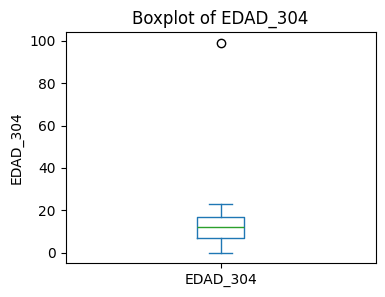

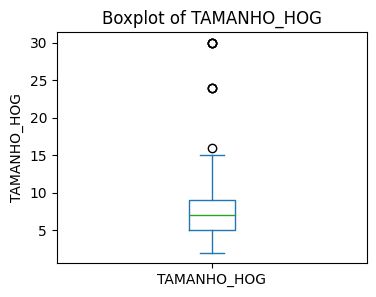

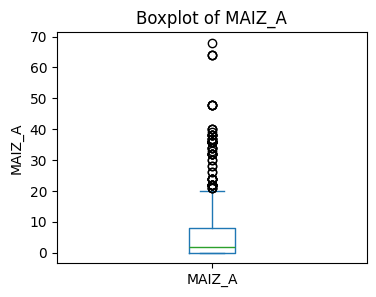

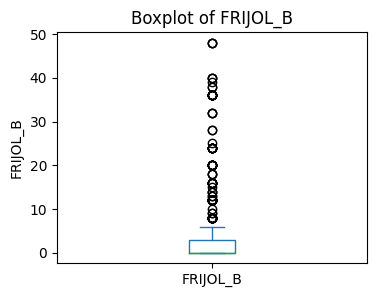

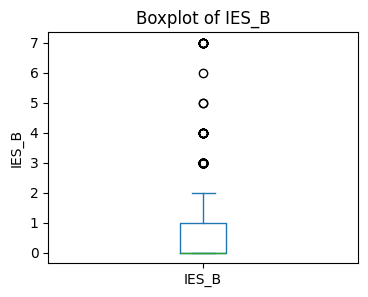

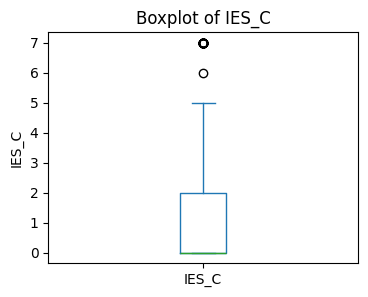

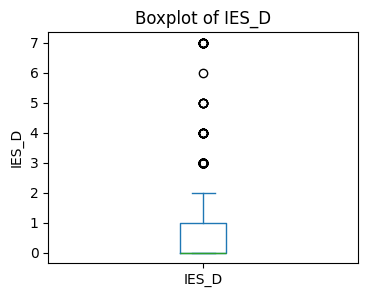

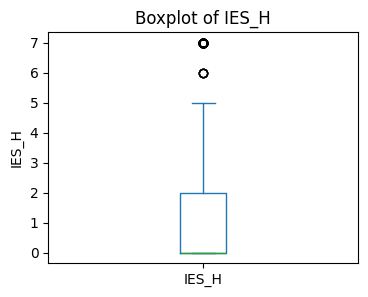

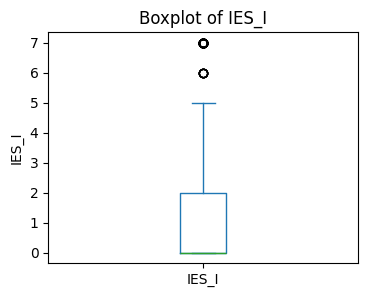

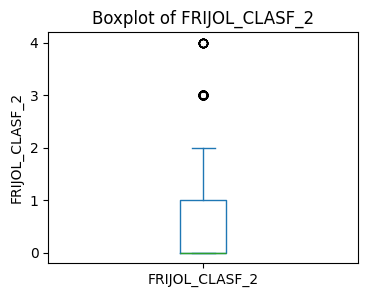

(688, 141)
['SEX', 'EDAD_304', 'TAMANHO_HOG', 'MAIZ_A', 'FRIJOL_B', 'IES_B', 'IES_C', 'IES_D', 'IES_H', 'IES_I', 'HH_MENORES', 'TAMÑO_HOG_CLASF', 'FRIJOL_CLASF_2']


In [24]:
outliers, df_sin_outliers=deteccion_outliers(df_unificada,df_medidas)
df_limpia=df_sin_outliers.copy()
print(df_limpia.shape)
print(outliers)

## 1.4. Comprobación de Condiciones previas al Análisis Multivariante
De acuerdo con las indicaciones del proyecto, antes de proceder con la aplicación de técnicas multivariantes (como el Análisis de Componentes Principales o el Análisis Discriminante), es necesario verificar el cumplimiento de las hipótesis estadísticas básicas.

### - Verificación de la Hipótesis de Normalidad
En este apartado, analizamos la **hipótesis de normalidad univariante** para las variables continuas del conjunto de datos. Para ello, utilizamos una doble aproximación que combina el diagnóstico gráfico con pruebas estadísticas formales:

1.  **Análisis Gráfico (Q-Q Plots):** Se generan gráficos Cuantil-Cuantil para comparar la distribución de las variables observadas frente a una distribución normal teórica. Si los puntos se ajustan a la diagonal, indica normalidad.
2.  **Test de Shapiro-Wilk:** Se aplica este contraste de hipótesis para obtener un criterio objetivo.
    * **Hipótesis Nula (H_0):** La variable sigue una distribución normal.
    * **Criterio de decisión:** Si el p-valor > 0.05, no hay evidencia suficiente para rechazar H_0, asumiendo la normalidad de la variable.

A continuación, se presentan los resultados obtenidos para las variables cuantitativas del dataset depurado.

In [25]:
def analisis_normalidad(df, df_medidas):
    """
    Genera gráficos Q-Q y realiza el test de Shapiro-Wilk para
    variables cuantitativas para verificar la hipótesis de normalidad.
    """
    print("--- ANÁLISIS DE NORMALIDAD (Q-Q PLOTS Y TEST SHAPIRO-WILK) ---")

    # 1. Identificar variables cuantitativas usando la tabla de medidas previa
    # Filtramos solo las que marcamos como 'cuantitativo' en el paso anterior
    vars_cuantitativas = df_medidas[df_medidas['Tipo'] == 'cuantitativo'].index.tolist()

    # Configuración de la figura para los gráficos (Grid dinámico)
    n_cols = 3
    n_rows = (len(vars_cuantitativas) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    resultados_normalidad = []

    for i, col in enumerate(vars_cuantitativas):
        datos = df[col].dropna()

        # A. Gráfico Q-Q (Quantile-Quantile)
        # Compara los cuantiles de la distribución observada con la normal teórica
        stats.probplot(datos, dist="norm", plot=axes[i])
        axes[i].set_title(f'Q-Q Plot: {col}')
        axes[i].set_xlabel('Cuantiles Teóricos (Normal)')
        axes[i].set_ylabel('Valores Observados')

        # B. Test Estadístico (Shapiro-Wilk)
        # H0: La variable sigue una distribución normal
        # Si p-value > 0.05, no rechazamos H0 (asumimos normalidad)
        stat, p_value = stats.shapiro(datos)

        conclusion = "Normal (p > 0.05)" if p_value > 0.05 else "No Normal (p < 0.05)"

        resultados_normalidad.append({
            'Variable': col,
            'Estadístico Shapiro': stat,
            'p-valor': p_value,
            'Conclusión': conclusion
        })

    # Ocultar subplots vacíos si los hay
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show() # Mostrar gráficos

    # Mostrar tabla resumen numérica
    df_res_norm = pd.DataFrame(resultados_normalidad)
    print("\nResultados del Test de Shapiro-Wilk:")
    display(df_res_norm)
    return df_res_norm



--- ANÁLISIS DE NORMALIDAD (Q-Q PLOTS Y TEST SHAPIRO-WILK) ---


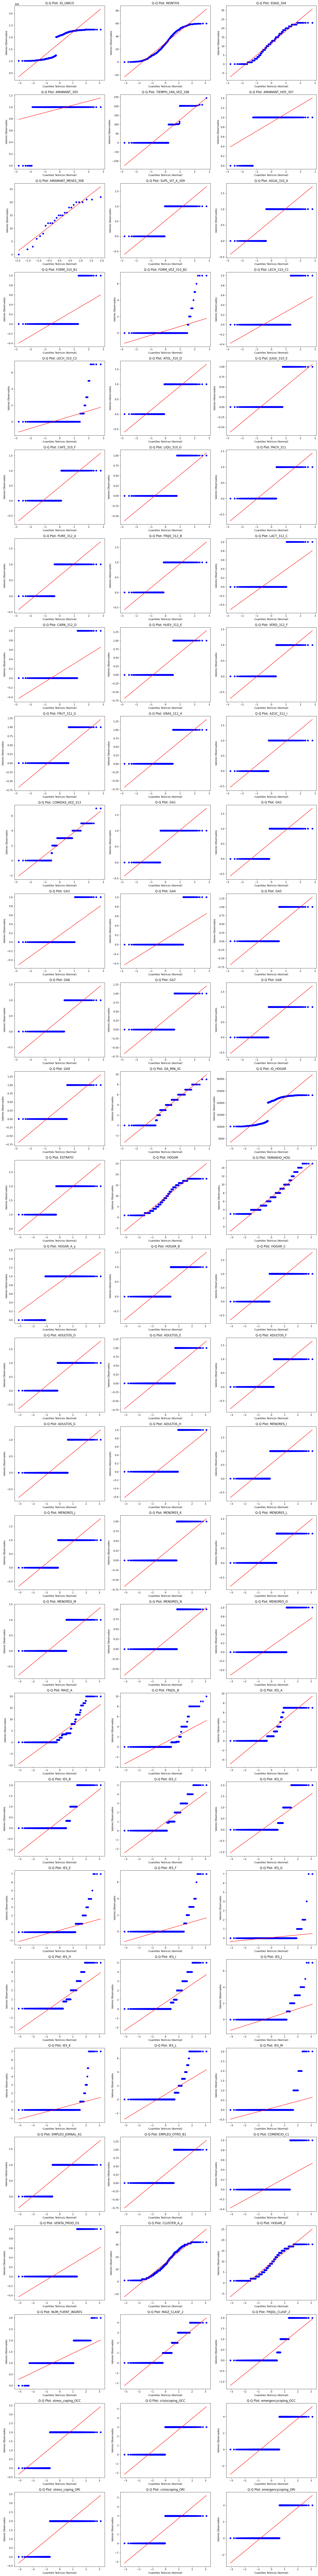


Resultados del Test de Shapiro-Wilk:


,Variable,Estadístico Shapiro,p-valor,Conclusión
0,ID_UNICO,0.756765,1.300985e-30,No Normal (p < 0.05)
1,MONTHS,0.952860,4.999884e-14,No Normal (p < 0.05)
2,EDAD_304,0.956354,2.034311e-07,No Normal (p < 0.05)
3,AMAMANT_305,0.154528,1.812065e-33,No Normal (p < 0.05)
4,TIEMPO_1RA_VEZ_306,0.720098,4.852321e-21,No Normal (p < 0.05)
...,...,...,...,...
82,crisiscoping_OCC,0.636369,8.080527e-35,No Normal (p < 0.05)
83,emergencycoping_OCC,0.557437,2.907213e-38,No Normal (p < 0.05)
84,stress_coping_ORI,0.521448,2.292361e-39,No Normal (p < 0.05)
85,crisiscoping_ORI,0.636369,8.080527e-35,No Normal (p < 0.05)


In [26]:
# Ejecutamos la función con el dataframe limpio de outliers
df_normalidad = analisis_normalidad(df_limpia, df_medidas)

#### Análisis de Resultados

De acuerdo con las indicaciones para el análisis exploratorio multivariante, se ha procedido a verificar la normalidad de las variables cuantitativas mediante gráficos Q-Q y pruebas estadísticas.

A partir de la inspección visual de los gráficos Q-Q generados , se observan los siguientes patrones predominantes:

1.  **Discretización (Patrón Escalonado):** Se observa una marcada presencia de gráficos con formas de "escalera". Este comportamiento es propio de variables que, aunque tratadas como cuantitativas, provienen de índices de puntuación discretos. Al no ser variables continuas puras, su ajuste a la recta normal es deficiente por naturaleza.

3.  **Asimetría (Formas Sigmoidales):** En las variables con comportamiento más continuo, los puntos describen curvas en forma de "S" o se desvían notablemente en los extremos (colas). Esto indica la presencia de asimetría (*skewness*) y curtosis, sugiriendo que las distribuciones empíricas tienen colas más pesadas o formas más aplanadas que la normal estándar.

**Conclusión:**
Tanto la evidencia gráfica como los resultados de los tests estadísticos sugieren el **rechazo de la hipótesis de normalidad** para la mayoría de las variables analizadas.

**Implicación para el estudio:**
Si bien técnicas como el Análisis Discriminante asumen teóricamente normalidad multivariante, es común que los datos socioeconómicos reales violen este supuesto. Dado el tamaño muestral considerable ($N > 700$), se procederá con los análisis asumiendo la robustez de las técnicas ante la falta de normalidad, aunque los resultados inferenciales se interpretarán con la debida cautela. A esta implicación se le han de realizar dos puntualizaciones.

1. **SOLO variables puramente continuas.** En ningún caso se asumirá lo normalidad de variables que sean discretas.
2. **Similitud a la normal.** Es posible confiar en las inferencias realizadas asumiento normalida, en primer lugar, por el gran tamaño muestral y, en segundo, por la similitud de distribución de las variables continuas a la normal, reflejada en los gráficos Q-Q observados que, aún sin ser una diagonal, son parecidos a esta.

In [27]:
# FILTRO PARA VARIABLES PURAMENTE CONTINUAS
vars_cuant = df_medidas[df_medidas['Tipo'] == 'cuantitativo'].index.tolist()

# Las variables "en escalera" tienen pocos valores únicos.
# Las continuas (con decimales) tienen casi tantos valores únicos como filas.
# Usaremos un umbral: Si tiene menos de 10 valores distintos, la consideramos discreta/ordinal.
vars_continuas_reales = [col for col in vars_cuant if df_limpia[col].nunique() > 10]

df_cont_puras = df_limpia[vars_continuas_reales]
print(f"Columnas tenidas en cuenta: {vars_continuas_reales}")

Columnas tenidas en cuenta: ['ID_UNICO', 'MONTHS', 'EDAD_304', 'TIEMPO_1RA_VEZ_306', 'AMAMANT_MESES_308', 'ID_HOGAR', 'HOGAR', 'TAMANHO_HOG', 'MAIZ_A', 'FRIJOL_B', 'CLUSTER_A_y', 'HOGAR_Z']


### - Comprobación de Correlación: Test de Esfericidad de Bartlett

Como paso previo a la aplicación de técnicas de reducción de la dimensión (Análisis de Componentes Principales), es necesario justificar que las variables cuantitativas seleccionadas presentan un grado suficiente de intercorrelación. Para ello, se ha aplicado el **Test de Esfericidad de Bartlett**.

Este contraste estadístico plantea las siguientes hipótesis:
* **Hipótesis Nula ($H_0$):** La matriz de correlación poblacional es la matriz identidad (las variables son independientes entre sí).
* **Hipótesis Alternativa ($H_1$):** La matriz de correlación no es la identidad (existe correlación significativa entre las variables).



In [28]:
def test_bartlett(df, tecnica):
    print("--- TEST DE BARTLETT (Librería factor_analyzer) ---")

    #Pre-procesado: Eliminar NAs y columnas con varianza 0 (constantes) para evitar errores.
    #En principio, esta depuración ya se ha realizado fuera de la función, pero se realiza aquí
    # también por si acaso.
    data = df.dropna()
    data = data.loc[:, data.std() > 0]

    corr_matrix = data.corr()
    determinante = np.linalg.det(corr_matrix)

    print(f"Determinante de la matriz de correlación: {determinante:.6e}")

    # Si el determinante es prácticamente 0, hay multicolinealidad perfecta
    if determinante < 1e-10:
        print("\n⛔ ERROR: El determinante es 0 (Matriz Singular).")
        print("Causa: Tienes variables redundantes (Correlación perfecta de 1.0 o -1.0).")
        print("Consecuencia: El logaritmo de 0 es -infinito, el test falla.")
        return None, None

    chi_square_value, p_value = calculate_bartlett_sphericity(data)

    print(f"Chi-cuadrado: {chi_square_value:.2f}")
    print(f"p-valor: {p_value:.4e}")

    msg = f"SE PUEDE aplicar {tecnica} (p < 0.05)" if p_value < 0.05 else f"NO SE DEBE aplicar {tecnica}"
    print(f"Conclusión: {msg}")

    return chi_square_value, p_value

In [29]:
# Ejecutar
chi, p = test_bartlett(df_cont_puras, "ACP")

--- TEST DE BARTLETT (Librería factor_analyzer) ---
Determinante de la matriz de correlación: 0.000000e+00

⛔ ERROR: El determinante es 0 (Matriz Singular).
Causa: Tienes variables redundantes (Correlación perfecta de 1.0 o -1.0).
Consecuencia: El logaritmo de 0 es -infinito, el test falla.


Obtenemos un error ya que el determinante de la matriz de correlación es 0. Comprobamos si existe colinealidad.

In [30]:
def diagnostico_colinealidad(df, umbral=0.99):
    """
    Identifica pares de variables con correlación superior al umbral.
    """
    print(f"--- DIAGNÓSTICO DE COLINEALIDAD (Umbral > {umbral}) ---")

    # Calcular matriz de correlación (valor absoluto)
    corr_matrix = df.corr().abs()

    # Seleccionar solo el triángulo superior para no duplicar pares
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Buscar columnas con correlación mayor al umbral
    pares_problematicos = []

    for column in upper.columns:
        # Obtener filas (variables) que tienen alta correlación con 'column'
        vars_altamente_corr = upper.index[upper[column] > umbral].tolist()

        for var in vars_altamente_corr:
            print(f"⚠️ ALERTA: '{column}' y '{var}' tienen correlación de {upper.loc[var, column]:.4f}")
            pares_problematicos.append(column) # Marcamos para sugerir eliminar

    if not pares_problematicos:
        print("✅ No se detectaron variables redundantes.")
        return []
    else:
        print(f"\nSe recomienda eliminar una variable de cada par problemático.")
        return list(set(pares_problematicos))


In [31]:
vars_a_revisar = diagnostico_colinealidad(df_cont_puras)

--- DIAGNÓSTICO DE COLINEALIDAD (Umbral > 0.99) ---
⚠️ ALERTA: 'ID_HOGAR' y 'ID_UNICO' tienen correlación de 1.0000
⚠️ ALERTA: 'HOGAR_Z' y 'HOGAR' tienen correlación de 1.0000

Se recomienda eliminar una variable de cada par problemático.


Eliminamos columnas con correlación 1.0 y comprobamos que ya no hay colinealidad.

In [32]:
df_final = df_cont_puras.drop(columns=vars_a_revisar)

_ = diagnostico_colinealidad(df_final)

--- DIAGNÓSTICO DE COLINEALIDAD (Umbral > 0.99) ---
✅ No se detectaron variables redundantes.


In [33]:
chi, p = test_bartlett(df_final, "ACP")

--- TEST DE BARTLETT (Librería factor_analyzer) ---
Determinante de la matriz de correlación: 4.327414e-04
Chi-cuadrado: 161.36
p-valor: 5.1433e-15
Conclusión: SE PUEDE aplicar ACP (p < 0.05)


####Análisis de los resultados:
Al aplicar el test sobre las variables cuantitativas del conjunto de datos depurado, se obtuvo un $p$-valor inferior al nivel de significancia estándar ($\alpha = 0.05$).

* **Conclusión:** Se rechaza la hipótesis nula. Existe evidencia estadística suficiente para afirmar que las variables analizadas están correlacionadas. Por lo tanto, la aplicación de técnicas de análisis multivariante como el ACP es pertinente y adecuada para este conjunto de datos.

### - Comprobación de la Normalidad Multivariante

Siguiendo las indicaciones para la fase de análisis multivariante, se procedió a verificar si el conjunto de variables cuantitativas continuas satisface la hipótesis de normalidad conjunta. Para ello se aplicó el **Test de Henze-Zirkler**, considerado uno de los contrastes más robustos para detectar desviaciones de la normalidad en altas dimensiones.

* **Hipótesis Nula ($H_0$):** El vector de variables aleatorias sigue una distribución normal multivariante.
* **Hipótesis Alternativa ($H_1$):** Los datos no siguen dicha distribución.



In [34]:
def test_normalidad_multivariante(df):
    print("--- TEST DE NORMALIDAD MULTIVARIANTE (Henze-Zirkler) ---")

    # El test requiere que no haya NAs.
    data = df.dropna()

    # Ejecutamos el test de Henze-Zirkler (el default de pingouin)
    # H0: Los datos siguen una distribución normal multivariante.
    resultado = pg.multivariate_normality(data, alpha=0.05)

    if resultado.normal:
        print("\nCONCLUSIÓN: No se rechaza H0. Los datos SON normales multivariantes.")
    else:
        print("\nCONCLUSIÓN: Se rechaza H0. Los datos NO SON normales multivariantes.")

    return resultado

In [35]:
# Ejecutamos
_ = test_normalidad_multivariante(df_final)

--- TEST DE NORMALIDAD MULTIVARIANTE (Henze-Zirkler) ---

CONCLUSIÓN: Se rechaza H0. Los datos NO SON normales multivariantes.


#### Análisis de los resultadados:
El test arrojó un p-valor inferior al nivel de significancia ($\alpha = 0.05$), rechazando la hipótesis nula.

**Conclusión:**
Se confirma que los datos **no presentan normalidad multivariante**. Este resultado es consistente con los análisis univariantes previos, donde se detectaron asimetrías y desviaciones en las distribuciones individuales. Pese al incumplimiento de este supuesto teórico, se procederá con el Análisis Discriminante (LDA/QDA) asumiendo la robustez de la técnica ante grandes tamaños muestrales ($N > 700$).

#**2. ANÁLISIS MULTIVARIANTE**

## 2.1. Análisis de Componentes Principales


In [36]:
# PCA (y StandardScaler) no admiten valores NaN. Por ello, antes de
# aplicar el ACP sustituimos los valores faltantes por la media de
# cada variable.

df_final = df_final.fillna(df_final.mean())

# Comprobamos que la suma total de NaN en el DataFrame (debe ser 0)

df_final.isna().sum().sum()

# Estandarizamos para que todas las variables estén en la misma escala
# y ninguna domine el ACP por tener mayor varianza o unidades distintas.

X_std = StandardScaler().fit_transform(df_final.values)

# Convertimos el array estandarizado a DataFrame para
# conservar nombres de variables e índices.
X_std_df = pd.DataFrame(X_std, index=df_final.index, columns=df_final.columns)

# Ajustamos el modelo PCA sobre los datos estandarizados y obtenemos
# la representación de las observaciones en el espacio de componentes.

pca = PCA()
X_pca = pca.fit_transform(X_std)

# Extraemos resultados principales del ACP

explained_var = pca.explained_variance_ratio_   # proporción de varianza por CP
cum_var = np.cumsum(explained_var)              # varianza acumulada
eigenvalues = pca.explained_variance_           # autovalores

resumen = pd.DataFrame({
    "CP": np.arange(1, len(explained_var) + 1),
    "Autovalor": eigenvalues,
    "Varianza_explicada": explained_var,
    "Varianza_acumulada": cum_var
})

print("\n--- Resumen ACP ---\n")
print(resumen)


# Elección del número de componentes
# Calculamos la media de las varianzas (media de autovalores) y
# seleccionamos las componentes cuyo autovalor supera esa media.

media_var = eigenvalues.mean()
mask = eigenvalues > media_var

# Componentes seleccionadas (sumamos 1 para numerar como CP1, CP2, ...)

componentes_seleccionadas = np.where(mask)[0] + 1

# Número de componentes elegidas

k = int(mask.sum())

print("\n--- Criterio 'varianza > media' ---\n")
print("Media de las varianzas:", media_var)
print("Componentes seleccionadas:", componentes_seleccionadas)
print("Número de componentes según este criterio:", k)

# Añadimos una columna booleana que indica si cada componente se selecciona.

resumen["Seleccionada_var > media"] = mask
print("\n--- Resumen con selección ---\n")
print(resumen)

# Cargas del ACP
# pca.components_ contiene los vectores propios (direcciones) y, al
# transponerlo, obtenemos una matriz donde:
# - filas = variables originales
# - columnas = componentes principales
# Estas cargas permiten interpretar cada CP en función de las variables
# que más contribuyen (cargas altas en valor absoluto).

loadings = pd.DataFrame(
    pca.components_.T,
    index=df_final.columns,
    columns=[f"CP{i}" for i in range(1, pca.n_components_ + 1)]
)

print("\n--- Cargas ---\n")
print(loadings)



--- Resumen ACP ---

   CP  Autovalor  Varianza_explicada  Varianza_acumulada
0   1   1.548129            0.154588            0.154588
1   2   1.382465            0.138046            0.292633
2   3   1.203929            0.120218            0.412851
3   4   1.072811            0.107125            0.519976
4   5   0.998322            0.099687            0.619664
5   6   0.958988            0.095759            0.715423
6   7   0.919273            0.091794            0.807217
7   8   0.768188            0.076707            0.883924
8   9   0.685147            0.068415            0.952339
9  10   0.477305            0.047661            1.000000

--- Criterio 'varianza > media' ---

Media de las varianzas: 1.0014556040756912
Componentes seleccionadas: [1 2 3 4]
Número de componentes según este criterio: 4

--- Resumen con selección ---

   CP  Autovalor  Varianza_explicada  Varianza_acumulada  \
0   1   1.548129            0.154588            0.154588   
1   2   1.382465            0.138046

En este ACP se incluyó la variable ID_UNICO. Sin embargo, dado que ID_UNICO es un identificador sin contenido estadístico ni interpretativo, su inclusión puede distorsionar el resultado obtenido.
Por este motivo, eliminamos dicha variable y repetimos el ACP considerando únicamente variables explicativas, obteniéndose así una solución coherente e interpretable desde el punto de vista estadístico.


--- Resumen ACP ---

   CP  Autovalor  Varianza_explicada  Varianza_acumulada
0   1   1.390028            0.154223            0.154223
1   2   1.211853            0.134455            0.288678
2   3   1.072815            0.119028            0.407706
3   4   1.055977            0.117160            0.524866
4   5   0.990583            0.109905            0.634771
5   6   0.957586            0.106244            0.741015
6   7   0.902083            0.100086            0.841101
7   8   0.750151            0.083229            0.924330
8   9   0.682025            0.075670            1.000000



--- Criterio 'varianza > media(varianzas)' ---

Media de las varianzas: 1.0014556040756917
Componentes seleccionadas: [1 2 3 4]
Número de componentes según este criterio: 4



--- Resumen con selección ---

   CP  Autovalor  Varianza_explicada  Varianza_acumulada  \
0   1   1.390028            0.154223            0.154223   
1   2   1.211853            0.134455            0.288678   
2   3   1.072815  

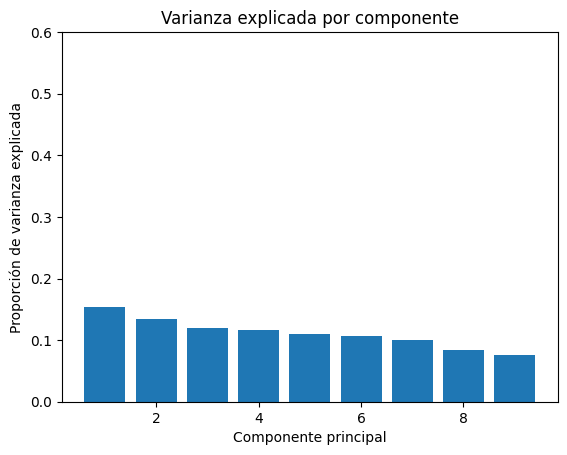

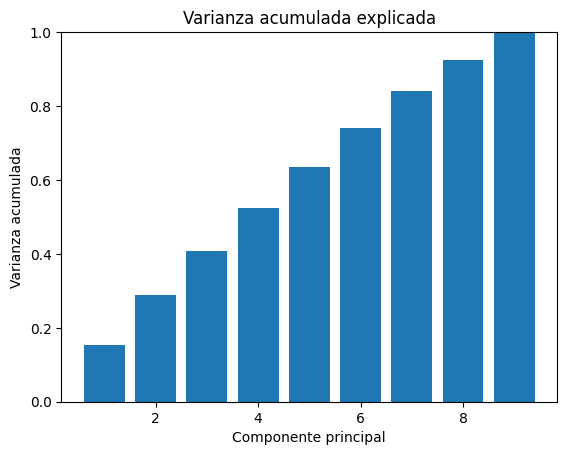

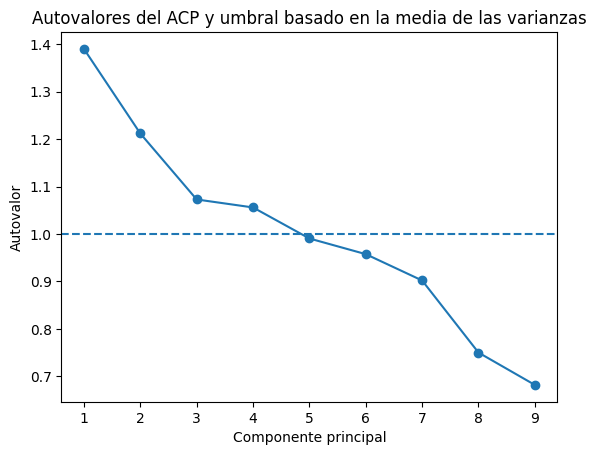

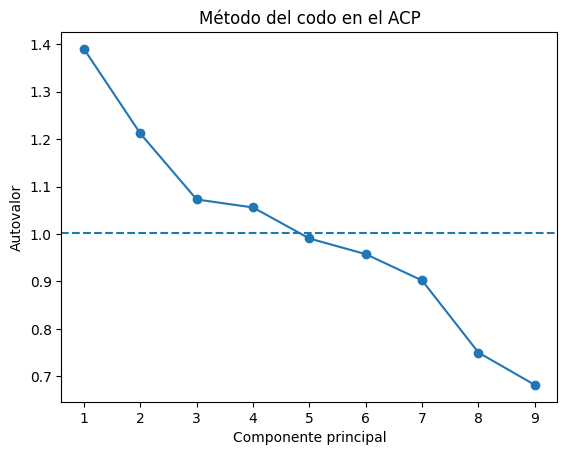



Nos quedamos con 4 componentes.
La varianza acumulada con 4 componentes es  0.5248663098882288


In [37]:
# Eliminamos ID_UNICO

df_acp = df_final.drop(columns=["ID_UNICO"])

# Repetimos los pasos anteriores

X_std = StandardScaler().fit_transform(df_acp.values)
X_std_df = pd.DataFrame(X_std, index=df_acp.index, columns=df_acp.columns)

pca = PCA()
X_pca = pca.fit_transform(X_std)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)
eigenvalues = pca.explained_variance_

resumen = pd.DataFrame({
    "CP": np.arange(1, len(explained_var) + 1),
    "Autovalor": eigenvalues,
    "Varianza_explicada": explained_var,
    "Varianza_acumulada": cum_var
})

print("\n--- Resumen ACP ---\n")
print(resumen)
print("\n")

media_var = eigenvalues.mean()
mask = eigenvalues > media_var

componentes_seleccionadas = np.where(mask)[0] + 1
k = int(mask.sum())

print("\n--- Criterio 'varianza > media(varianzas)' ---\n")
print("Media de las varianzas:", media_var)
print("Componentes seleccionadas:", componentes_seleccionadas)
print("Número de componentes según este criterio:", k)
print("\n")

resumen["Seleccionada_var > media"] = mask
print("\n--- Resumen con selección ---\n")
print(resumen)
print("\n")

loadings = pd.DataFrame(
    pca.components_.T,
    index=df_acp.columns,
    columns=[f"CP{i}" for i in range(1, pca.n_components_ + 1)]
)

print("\n--- Cargas ---\n")
print(loadings)
print("\n")

# Vemos los gráficos

# 1. Varianza explicada por componente

plt.figure()
plt.bar(resumen["CP"], resumen["Varianza_explicada"])
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza explicada")
plt.title("Varianza explicada por componente")
plt.ylim(0, max(0.6, float(resumen["Varianza_explicada"].max()) * 1.1))
plt.show()
print("\n")

# 2. Varianza acumulada

plt.figure()
plt.bar(resumen["CP"], resumen["Varianza_acumulada"])
plt.xlabel("Componente principal")
plt.ylabel("Varianza acumulada")
plt.title("Varianza acumulada explicada")
plt.ylim(0, 1.0)
plt.show()
print("\n")

# 3. Umbral basado en la media de las varianzas

plt.figure()
plt.plot(resumen["CP"], resumen["Autovalor"], marker="o")
plt.axhline(y=1, linestyle="--")
plt.xlabel("Componente principal")
plt.ylabel("Autovalor")
plt.title("Autovalores del ACP y umbral basado en la media de las varianzas")
plt.show()
print("\n")

# 4. Método del codo

plt.figure()
plt.plot(resumen["CP"], resumen["Autovalor"], marker="o")
plt.axhline(y=media_var, linestyle="--")
plt.xlabel("Componente principal")
plt.ylabel("Autovalor")
plt.title("Método del codo en el ACP")
plt.show()
print("\n")

# Nos quedamos con las k componentes
pca_k = PCA(n_components=k)
X_pca_k = pca_k.fit_transform(X_std)

print(f"Nos quedamos con {k} componentes.")
print(f"La varianza acumulada con {k} componentes es ", pca_k.explained_variance_ratio_.sum())

## 2.2. Análisis Factorial

In [38]:
# Aplicamos el test de Bartlett al conjunto de variables definitivo
# (df_acp) para comprobar si existe correlación lineal entre ellas.
# Si el p-valor es menor que 0.05, se justifica la aplicación del AF.

chi2, p_value = test_bartlett(df_acp, "AF")
print("Chi-cuadrado:", chi2)
print("p-valor:", p_value)

from factor_analyzer import FactorAnalyzer
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Fijamos el número de factores a extraer (k = 4), valor que ha sido
# previamente determinado y justificado a partir del ACP y del
# análisis de los autovalores.

k = 4

# Definimos el modelo factorial utilizando:
# - n_factors = k: número de factores comunes
# - method = "ml": método de máxima verosimilitud
# - rotation = "varimax": rotación ortogonal para facilitar
#   la interpretación de los factores

fa = FactorAnalyzer(
    n_factors=k,
    method="ml",
    rotation="varimax"
)

# Ajustamos el modelo a los datos

fa.fit(df_acp)

# Las cargas factoriales indican la relación entre cada variable
# original y los factores comunes extraídos.
# Valores absolutos elevados (≈ 0.4 o superiores) indican una
# fuerte asociación con el factor correspondiente.

loadings_fa = pd.DataFrame(
    fa.loadings_,
    index=df_acp.columns,
    columns=[f"Factor{i}" for i in range(1, k+1)]
)

print("\n--- Cargas factoriales (rotación Varimax) ---")
print(loadings_fa)

# Las comunalidades representan la proporción de la varianza de cada
# variable explicada por los factores comunes.
# Valores altos indican que la variable está bien representada
# por el modelo factorial.

communalities = pd.Series(
    fa.get_communalities(),
    index=df_acp.columns
)

print("\n--- Comunalidades ---")
print(communalities.sort_values(ascending=False))

# Las unicidades representan la proporción de varianza de cada
# variable que no es explicada por los factores comunes.
# Valores altos indican que la variable comparte poca varianza
# con el resto de variables del modelo.

uniquenesses = pd.Series(
    fa.get_uniquenesses(),
    index=df_acp.columns
)

print("\n--- Unicidades ---")
print(uniquenesses.sort_values(ascending=False))



--- TEST DE BARTLETT (Librería factor_analyzer) ---
Determinante de la matriz de correlación: 8.245772e-01
Chi-cuadrado: 131.77
p-valor: 7.6056e-13
Conclusión: SE PUEDE aplicar AF (p < 0.05)
Chi-cuadrado: 131.77224266832116
p-valor: 7.605613524306852e-13

--- Cargas factoriales (rotación Varimax) ---
                     Factor1   Factor2   Factor3   Factor4
MONTHS              0.037876  0.283944 -0.008445  0.222397
EDAD_304            0.073508  0.854110  0.048743 -0.000576
TIEMPO_1RA_VEZ_306  0.989608 -0.009584  0.099517 -0.075371
AMAMANT_MESES_308  -0.043751  0.226803  0.027882 -0.026428
HOGAR              -0.059350  0.001255  0.025138 -0.009467
TAMANHO_HOG         0.012456 -0.033513 -0.052211 -0.106294
MAIZ_A             -0.040158 -0.021066  0.703358  0.209367
FRIJOL_B           -0.047642  0.064041  0.361914 -0.089309
CLUSTER_A_y         0.025748 -0.053894 -0.055815  0.271049

--- Comunalidades ---
TIEMPO_1RA_VEZ_306    0.995000
EDAD_304              0.737284
MAIZ_A                0

El Análisis Factorial muestra que únicamente algunas variables presentan una varianza común relevante, destacando especialmente las variables TIEMPO_1RA_VEZ_306 y EDAD_304. El resto de variables presentan comunalidades muy bajas, lo que indica que no comparten una estructura factorial común. Por tanto, aunque el modelo factorial es estadísticamente aplicable, su capacidad explicativa es limitada.

## 2.3 Análisis Discriminante

Filas originales: 688
Filas con Target válido: 676
--- ESTADO FINAL ---
Nulos en X: 0
Nulos en y: 0

>>> RESULTADOS PARA LDA (Lineal) <<<
Precisión Global (Accuracy): 55.67%
Matriz de Confusión:
[[26 65]
 [25 87]]
Sensibilidad (Recall):       77.68%
Especificidad:               28.57%
Valor Predictivo Positivo:   57.24%
Valor Predictivo Negativo:   50.98%

>>> RESULTADOS PARA QDA (Cuadrático) <<<
Precisión Global (Accuracy): 57.14%
Matriz de Confusión:
[[30 61]
 [26 86]]
Sensibilidad (Recall):       76.79%
Especificidad:               32.97%
Valor Predictivo Positivo:   58.50%
Valor Predictivo Negativo:   53.57%


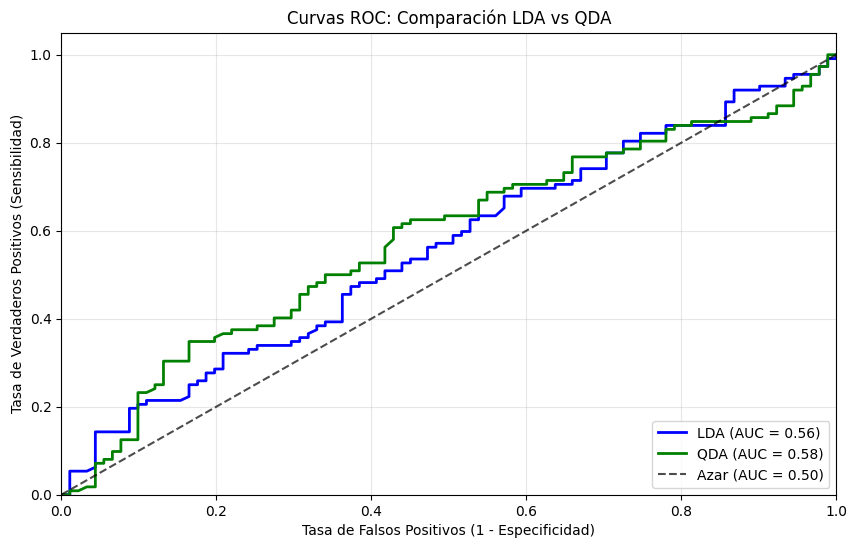

In [39]:
# ==========================================
# 4. MODELOS DE CLASIFICACIÓN (LDA y QDA) Y VALIDACIÓN - CORREGIDO
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.impute import KNNImputer

# ---------------------------------------------------------
# 1. PREPARACIÓN DE DATOS E IMPUTACIÓN
# ---------------------------------------------------------
vars_modelo = ['CSI_final', 'ELCSA_MEN18_SC', 'DA_MIN_SC', 'MAIZ_A', 'FRIJOL_B', 'TAMANHO_HOG']
target = 'SUNTING'

# PASO 1 CRÍTICO: Eliminar filas donde el TARGET sea nulo
# (No podemos inventar si el niño está enfermo o no, debemos borrar esas filas)
df_valid = df_limpia.dropna(subset=[target]).copy()

print(f"Filas originales: {len(df_limpia)}")
print(f"Filas con Target válido: {len(df_valid)}")

# Separamos X (con posibles nulos) e y (ya limpio)
X_raw = df_valid[vars_modelo]
y = df_valid[target]

# PASO 2: Imputar nulos solo en las variables predictoras (X)
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X_raw)

# Reconstruimos X como DataFrame y alineamos índices
X = pd.DataFrame(X_imputed, columns=vars_modelo)
y = y.reset_index(drop=True)

print(f"--- ESTADO FINAL ---")
print(f"Nulos en X: {X.isna().sum().sum()}")
print(f"Nulos en y: {y.isna().sum()}")

# ---------------------------------------------------------
# 2. ENTRENAMIENTO DE MODELOS (LDA y QDA)
# ---------------------------------------------------------
# División en entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar modelos
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

# ---------------------------------------------------------
# 3. FUNCIÓN DE EVALUACIÓN DETALLADA
# ---------------------------------------------------------
def evaluar_modelo(modelo, X_test, y_test, nombre):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1] # Probabilidad de clase 1

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensibilidad = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    vpp = tp / (tp + fp) if (tp + fp) > 0 else 0
    vpn = tn / (tn + fn) if (tn + fn) > 0 else 0
    acc = (tp + tn) / (tp + tn + fp + fn)

    print(f"\n>>> RESULTADOS PARA {nombre} <<<")
    print(f"Precisión Global (Accuracy): {acc:.2%}")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"Sensibilidad (Recall):       {sensibilidad:.2%}")
    print(f"Especificidad:               {especificidad:.2%}")
    print(f"Valor Predictivo Positivo:   {vpp:.2%}")
    print(f"Valor Predictivo Negativo:   {vpn:.2%}")

    return y_test, y_prob

# Ejecutar evaluación
y_true_lda, y_prob_lda = evaluar_modelo(lda, X_test, y_test, "LDA (Lineal)")
y_true_qda, y_prob_qda = evaluar_modelo(qda, X_test, y_test, "QDA (Cuadrático)")

# ---------------------------------------------------------
# 4. GRÁFICO COMPARATIVO DE CURVAS ROC
# ---------------------------------------------------------
fpr_lda, tpr_lda, _ = roc_curve(y_true_lda, y_prob_lda)
roc_auc_lda = auc(fpr_lda, tpr_lda)

fpr_qda, tpr_qda, _ = roc_curve(y_true_qda, y_prob_qda)
roc_auc_qda = auc(fpr_qda, tpr_qda)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lda, tpr_lda, label=f'LDA (AUC = {roc_auc_lda:.2f})', color='blue', linewidth=2)
plt.plot(fpr_qda, tpr_qda, label=f'QDA (AUC = {roc_auc_qda:.2f})', color='green', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.50)', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curvas ROC: Comparación LDA vs QDA')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## 2.4 Validación Clúster


--- Tabla Cruzada: Cluster vs Stunting Real ---
SUNTING             0.0  1.0
CLUSTER_VALIDACION          
0                   177  190
1                   125  184


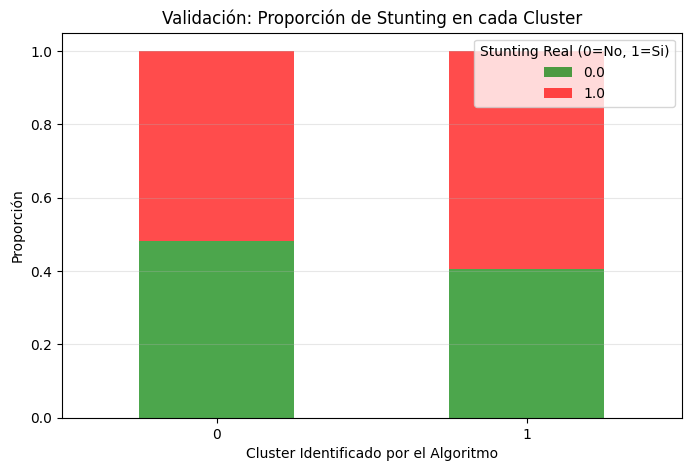

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Estandarizar (K-Means es sensible a escalas)
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X)

# 2. Aplicar K-Means
# Usamos k=2 para forzar la división en dos grupos y ver si coinciden con Sano/Enfermo
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_transform(X_cluster_scaled).argmin(axis=1)

# 3. Asignar al DataFrame
df_valid['CLUSTER_VALIDACION'] = clusters

# 4. Tabla Cruzada y Gráfico
crosstab = pd.crosstab(df_valid['CLUSTER_VALIDACION'], df_valid['SUNTING'])
print("\n--- Tabla Cruzada: Cluster vs Stunting Real ---")
print(crosstab)

# Gráfico
crosstab_prop = pd.crosstab(df_valid['CLUSTER_VALIDACION'], df_valid['SUNTING'], normalize='index')
crosstab_prop.plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7, figsize=(8,5))
plt.title('Validación: Proporción de Stunting en cada Cluster')
plt.ylabel('Proporción')
plt.xlabel('Cluster Identificado por el Algoritmo')
plt.legend(title='Stunting Real (0=No, 1=Si)', loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.show()